<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **TF-IDF analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), September 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions at the aggregated document level to answer: "Does context cue
influence METs more than the music itself?"

Analysis approach:
- Works with aggregated documents (called "METdocs") ONLY
  - TF-IDF is a bag-of-words method optimised for document-level analysis with
    sufficient word overlap. Individual short texts (10-50 words) produce extremely
    sparse vectors with minimal lexical overlap, resulting in artificially low
    similarity values that do not reflect semantic relationships.
  - BERT and Word2Vec handle individual-level analysis as they capture semantic
    meaning beyond exact word matches.
- Aggregates all thoughts from each clip-context pair into documents (N=64)
- Calculates pairwise cosine similarities between METdocs
- Categorises document pairs by their stimuli conditions to compare similarity distributions
- Tests whether aggregated thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity at the document level?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in aggregated METs?

Note: This document-level analysis complements the individual-level analyses
conducted with BERT and Word2Vec, providing a lexical perspective on semantic patterns.

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Cloning into 'context-framed-listening'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 441 (delta 6), reused 0 (delta 0), pack-reused 424 (from 2)
Receiving objects: 100% (441/441), 219.35 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (197/197), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

---
## ANALYSIS AT COMBINED METdoc LEVEL

TF-IDF (Term Frequency-Inverse Document Frequency) is a bag-of-words approach
that weights words by their importance within documents relative to a corpus.
This method is optimized for document-level analysis where texts are long enough
to contain sufficient word overlap for meaningful similarity comparisons.

Analysis structure:
- Aggregates all thoughts from each clip-context pair into documents (N=64)
- Each METdoc represents the collective semantic profile of one experimental condition
- Compares documents using cosine similarity of TF-IDF vectors
- Uses identical condition categories as BERT and Word2Vec for cross-method comparison

Purpose: Examine lexical similarity patterns at the aggregated level
- Shows which condition pairs share similar vocabulary and word usage patterns
- Complements semantic similarity analyses from BERT and Word2Vec
- Useful for understanding document-level semantic profiles


Load in the data file "**METdocsLVL2.csv**" that contains the preprocessed text data of participants' thought desciptions grouped into "METdocs", generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [3]:
# Load TF-IDF-appropriate aggregated METdocs
print("Loading aggregated METdocs...")
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL2.csv')
text_column = 'METdescr_prepLVL2'

print(f"Total METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")

Loading aggregated METdocs...
Total METdocs (clip-context pairs): 64
Unique clips: 16
Unique contexts: 4


### TF-IDF Vectorisation

In [4]:
print("\nComputing TF-IDF vectors for aggregated METdocs...")

# Initialise TF-IDF vectorizer
tfidf_vectorizer_docs = TfidfVectorizer(sublinear_tf=False)

# Fit and transform METdocs
tfidf_matrix_docs = tfidf_vectorizer_docs.fit_transform(METdocs[text_column].astype(str))

print(f"TF-IDF matrix shape: {tfidf_matrix_docs.shape}")
print(f"Number of unique terms: {len(tfidf_vectorizer_docs.get_feature_names_out())}")

# Save TF-IDF scores for METdocs
df_TFIDF_docs = pd.DataFrame(
    tfidf_matrix_docs.toarray(),
    columns=tfidf_vectorizer_docs.get_feature_names_out(),
    index=METdocs['ClipContext_pair']
)
df_TFIDF_docs.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_scores.csv',
                      encoding='utf-8')


Computing TF-IDF vectors for aggregated METdocs...
TF-IDF matrix shape: (64, 3325)
Number of unique terms: 3325


### Cosine Similarity Matrix


Calculating cosine similarity matrix...

TF-IDF Cosine Similarity Matrix (METdocs level):


ClipContext_pair,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
ClipContext_pair,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.341980,0.358179,0.358328,0.344184,0.345180,0.408953,0.340433,0.321841,0.359571,...,0.392228,0.346242,0.286943,0.334202,0.380768,0.437105,0.332314,0.267711,0.310773,0.310947
BAR-80s_LOW_06,0.341980,1.000000,0.426238,0.335442,0.355636,0.407451,0.313701,0.325606,0.336328,0.440361,...,0.298549,0.266112,0.287858,0.286771,0.371370,0.391684,0.296229,0.230518,0.260956,0.274753
BAR-80s_MED_08,0.358179,0.426238,1.000000,0.424640,0.387232,0.445359,0.362594,0.360172,0.401012,0.452967,...,0.387771,0.315025,0.333351,0.403461,0.407920,0.394449,0.358442,0.303518,0.344153,0.332642
BAR-80s_MED_13,0.358328,0.335442,0.424640,1.000000,0.376855,0.370450,0.375945,0.321061,0.410123,0.362957,...,0.386010,0.357943,0.376403,0.361567,0.383822,0.385968,0.368329,0.287007,0.340189,0.336044
BAR-Ele_LOW_09,0.344184,0.355636,0.387232,0.376855,1.000000,0.413536,0.368102,0.331279,0.354978,0.395798,...,0.354968,0.334759,0.351387,0.348050,0.348303,0.333701,0.376711,0.329743,0.387856,0.355314


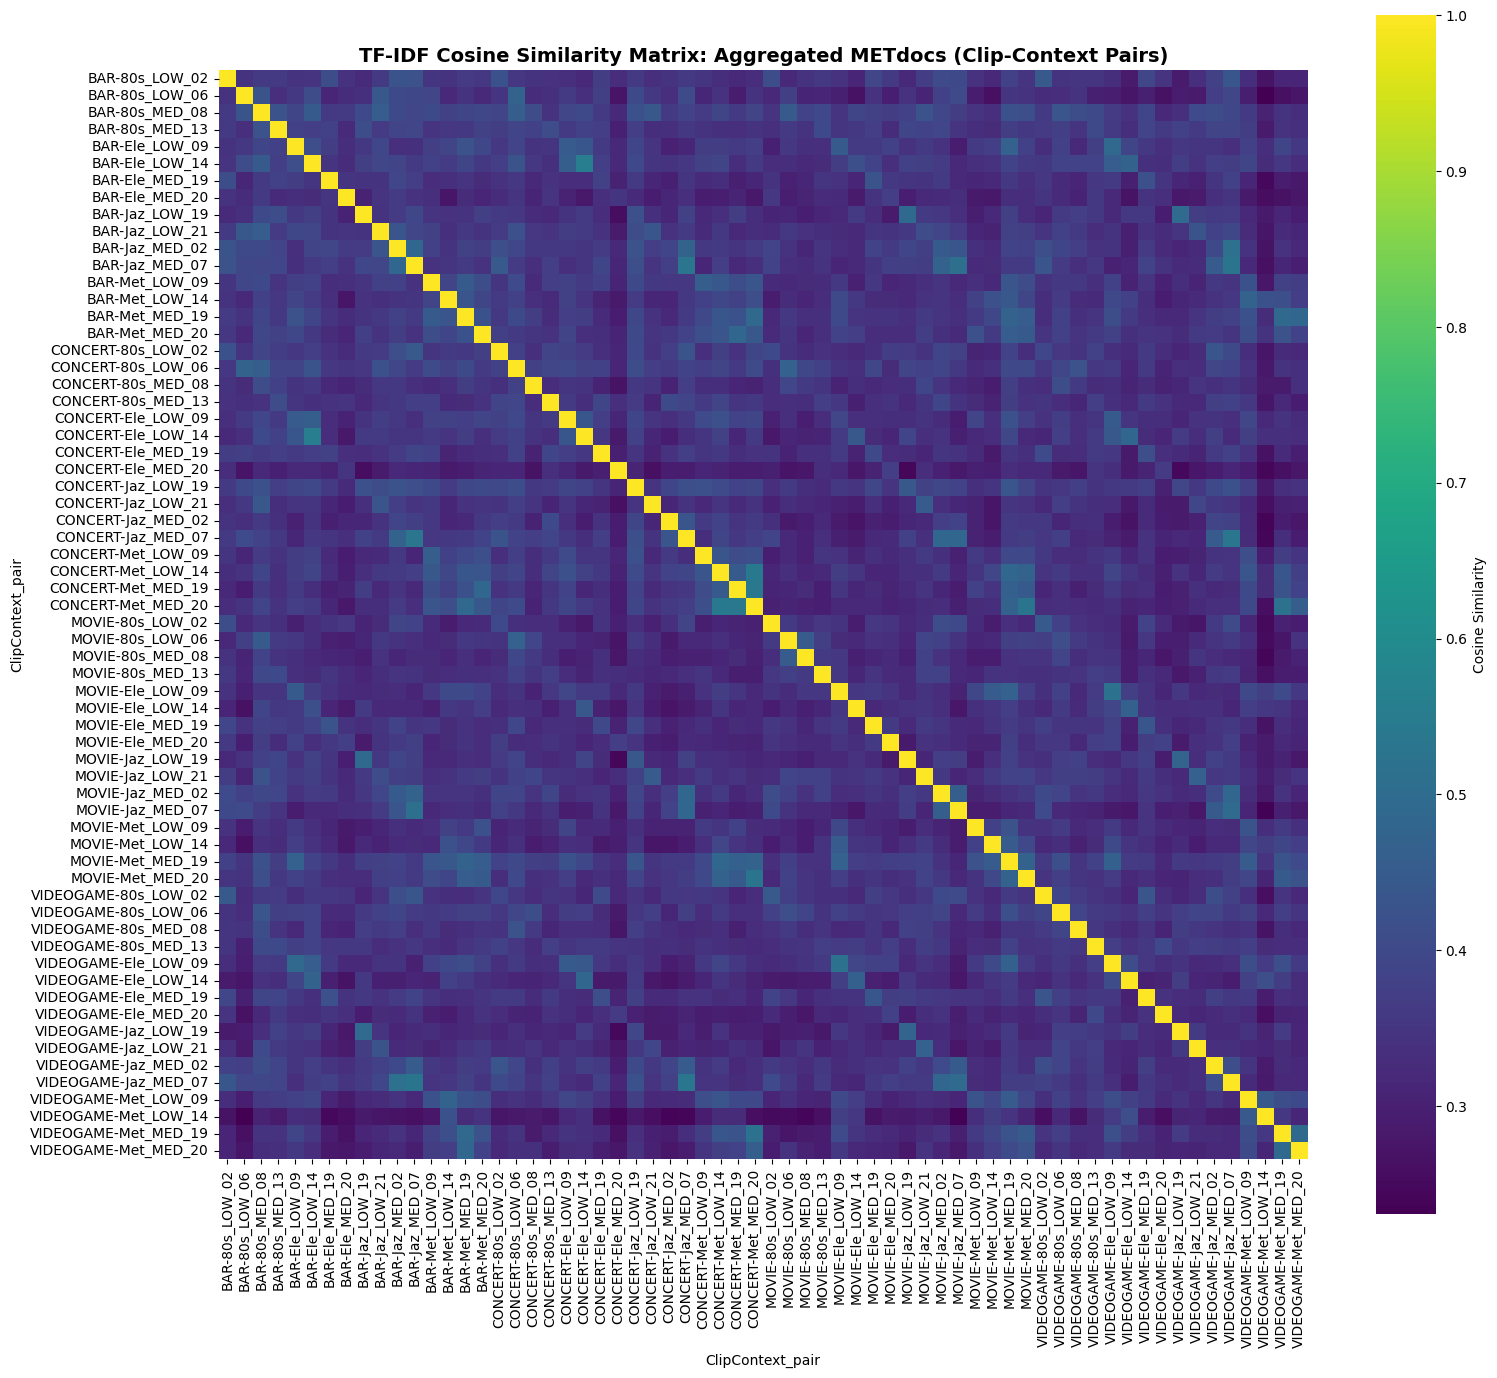

In [5]:
print("\nCalculating cosine similarity matrix...")
cosineMatrix_TFIDF = cosine_similarity(tfidf_matrix_docs, tfidf_matrix_docs)

# Create labeled DataFrame
cosineMatrix_TFIDF_df = pd.DataFrame(
    cosineMatrix_TFIDF,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save cosine similarity matrix
cosineMatrix_TFIDF_df.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_cosineMatrix.csv',
                               encoding='utf-8')

print("\nTF-IDF Cosine Similarity Matrix (METdocs level):")
display(cosineMatrix_TFIDF_df.head())

plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_TFIDF_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('TF-IDF Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_heatmap_TFIDF.png',
            dpi=300, bbox_inches='tight')
plt.show()

### Similarity Values by Condition

In [6]:
print("\nExtracting similarity values by condition...")

clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

n_docs = len(METdocs)
print(f"Processing {(n_docs * (n_docs - 1)) // 2} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        sim_value = cosineMatrix_TFIDF[i, j]

        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # DETAILED CONDITIONS (for specific comparisons)
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'
        else:
            condition = 'other'  # shouldn't happen but safeguard

        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

sim_df_docs = pd.DataFrame(similarity_data)
sim_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_similarity_by_condition.csv',
                    index=False)

print("\nMETdocs-level similarity measures extracted:")
print(sim_df_docs.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values by condition...
Processing 2016 unique document pairs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

METdocs-level similarity measures extracted:
                                   count      mean       std       min  \
condition                                                                
diff_clip_diff_context_diff_genre   1152  0.335158  0.033651  0.230518   
diff_clip_diff_context_same_genre    288  0.363182  0.048555  0.257666   
diff_clip_same_context               480  0.354024  0.040283  0.259544   
same_clip_diff_context                96  0.422625  0.050381  0.326656   

                                        max  
condition                                    
diff_clip_diff_context_diff_genre  0.465631  
diff_clip_diff_context_same_genre  0.518031  
diff_clip_same_context             0.540833  
same_c

### STATISTICAL COMPARISONS



In [7]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two specific conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    if len(data1) < 2 or len(data2) < 2:
        print(f"WARNING: Insufficient data for {label1} vs {label2}")
        return None

    t_stat, p_value = stats.ttest_ind(data1, data2)
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }


def compare_binary(df, column, label):
    """Compare same vs different for a binary factor."""
    same_data = df[df[column] == True]['similarity']
    diff_data = df[df[column] == False]['similarity']

    t_stat, p_value = stats.ttest_ind(same_data, diff_data)
    pooled_std = np.sqrt((same_data.std()**2 + diff_data.std()**2) / 2)
    effect_size = (same_data.mean() - diff_data.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"Same {label} vs Different {label}",
        'mean_same': same_data.mean(),
        'mean_diff': diff_data.mean(),
        'diff': same_data.mean() - diff_data.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n_same': len(same_data),
        'n_diff': len(diff_data)
    }

# Store results
binary_comparisons = []
combined_comparisons = []

#### Binary Comparisons (Same vs Different for each factor)
Testing whether sharing a factor (clip/context/genre) increases similarity
1. CLIP EFFECT: Same vs Different
2. CONTEXT EFFECT: Same vs Different
3. GENRE EFFECT: Same vs Different
4. KEY COMPARISON: Which factor matters most?



In [8]:
print("\n" + "-"*70)
print("BINARY COMPARISONS - Fundamental Effects")
print("-"*70)
print("Testing whether sharing a factor (clip/context/genre) increases similarity")

# 1. CLIP EFFECT: Same vs Different
print("\n1. CLIP EFFECT: Same Clip vs Different Clip")
print("-" * 70)
clip_comp = compare_binary(sim_df_docs, 'same_clip', 'Clip')
binary_comparisons.append(clip_comp)

print(f"Same clip: M={clip_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_same']})")
print(f"Different clip: M={clip_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_clip']]['similarity'].std():.4f} (N={clip_comp['n_diff']})")
print(f"Difference: {clip_comp['diff']:.4f}")
print(f"t({clip_comp['n_same'] + clip_comp['n_diff'] - 2}) = {clip_comp['t']:.3f}, p = {clip_comp['p']:.4f} {clip_comp['sig']}")
print(f"Cohen's d = {clip_comp['d']:.3f}")

if clip_comp['mean_same'] > clip_comp['mean_diff']:
    print("→ Sharing the same CLIP significantly increases similarity")
else:
    print("→ Same clip does NOT significantly increase similarity")


# 2. CONTEXT EFFECT: Same vs Different
print("\n\n2. CONTEXT EFFECT: Same Context vs Different Context")
print("-" * 70)
context_comp = compare_binary(sim_df_docs, 'same_context', 'Context')
binary_comparisons.append(context_comp)

print(f"Same context: M={context_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_same']})")
print(f"Different context: M={context_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_context']]['similarity'].std():.4f} (N={context_comp['n_diff']})")
print(f"Difference: {context_comp['diff']:.4f}")
print(f"t({context_comp['n_same'] + context_comp['n_diff'] - 2}) = {context_comp['t']:.3f}, p = {context_comp['p']:.4f} {context_comp['sig']}")
print(f"Cohen's d = {context_comp['d']:.3f}")

if context_comp['mean_same'] > context_comp['mean_diff']:
    print("→ Sharing the same CONTEXT significantly increases similarity")
else:
    print("→ Same context does NOT significantly increase similarity")


# 3. GENRE EFFECT: Same vs Different
print("\n\n3. GENRE EFFECT: Same Genre vs Different Genre")
print("-" * 70)
genre_comp = compare_binary(sim_df_docs, 'same_genre', 'Genre')
binary_comparisons.append(genre_comp)

print(f"Same genre: M={genre_comp['mean_same']:.4f}, SD={sim_df_docs[sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_same']})")
print(f"Different genre: M={genre_comp['mean_diff']:.4f}, SD={sim_df_docs[~sim_df_docs['same_genre']]['similarity'].std():.4f} (N={genre_comp['n_diff']})")
print(f"Difference: {genre_comp['diff']:.4f}")
print(f"t({genre_comp['n_same'] + genre_comp['n_diff'] - 2}) = {genre_comp['t']:.3f}, p = {genre_comp['p']:.4f} {genre_comp['sig']}")
print(f"Cohen's d = {genre_comp['d']:.3f}")

if genre_comp['mean_same'] > genre_comp['mean_diff']:
    print("→ Sharing the same GENRE significantly increases similarity")
else:
    print("→ Same genre does NOT significantly increase similarity")


# KEY COMPARISON: Which factor matters most?
print("\n\n" + "="*70)
print("KEY FINDING: Comparing Binary Effects")
print("="*70)

effects = [
    ('CLIP', clip_comp['d'], clip_comp['diff']),
    ('CONTEXT', context_comp['d'], context_comp['diff']),
    ('GENRE', genre_comp['d'], genre_comp['diff'])
]
effects_sorted = sorted(effects, key=lambda x: abs(x[1]), reverse=True)

print("\nEffect sizes ranked (absolute Cohen's d):")
for i, (factor, d, diff) in enumerate(effects_sorted, 1):
    print(f"  {i}. {factor}: d = {d:.3f}, mean difference = {diff:.4f}")

print(f"\n→ {effects_sorted[0][0]} has the LARGEST effect on thought similarity")
print(f"→ {effects_sorted[1][0]} has a MODERATE effect")
print(f"→ {effects_sorted[2][0]} has the SMALLEST effect")


----------------------------------------------------------------------
BINARY COMPARISONS - Fundamental Effects
----------------------------------------------------------------------
Testing whether sharing a factor (clip/context/genre) increases similarity

1. CLIP EFFECT: Same Clip vs Different Clip
----------------------------------------------------------------------
Same clip: M=0.4226, SD=0.0504 (N=96)
Different clip: M=0.3441, SD=0.0395 (N=1920)
Difference: 0.0785
t(2014) = 18.718, p = 0.0000 ***
Cohen's d = 1.734
→ Sharing the same CLIP significantly increases similarity


2. CONTEXT EFFECT: Same Context vs Different Context
----------------------------------------------------------------------
Same context: M=0.3540, SD=0.0403 (N=480)
Different context: M=0.3459, SD=0.0442 (N=1536)
Difference: 0.0081
t(2014) = 3.594, p = 0.0003 ***
Cohen's d = 0.193
→ Sharing the same CONTEXT significantly increases similarity


3. GENRE EFFECT: Same Genre vs Different Genre
-----------------

##### Visualisation

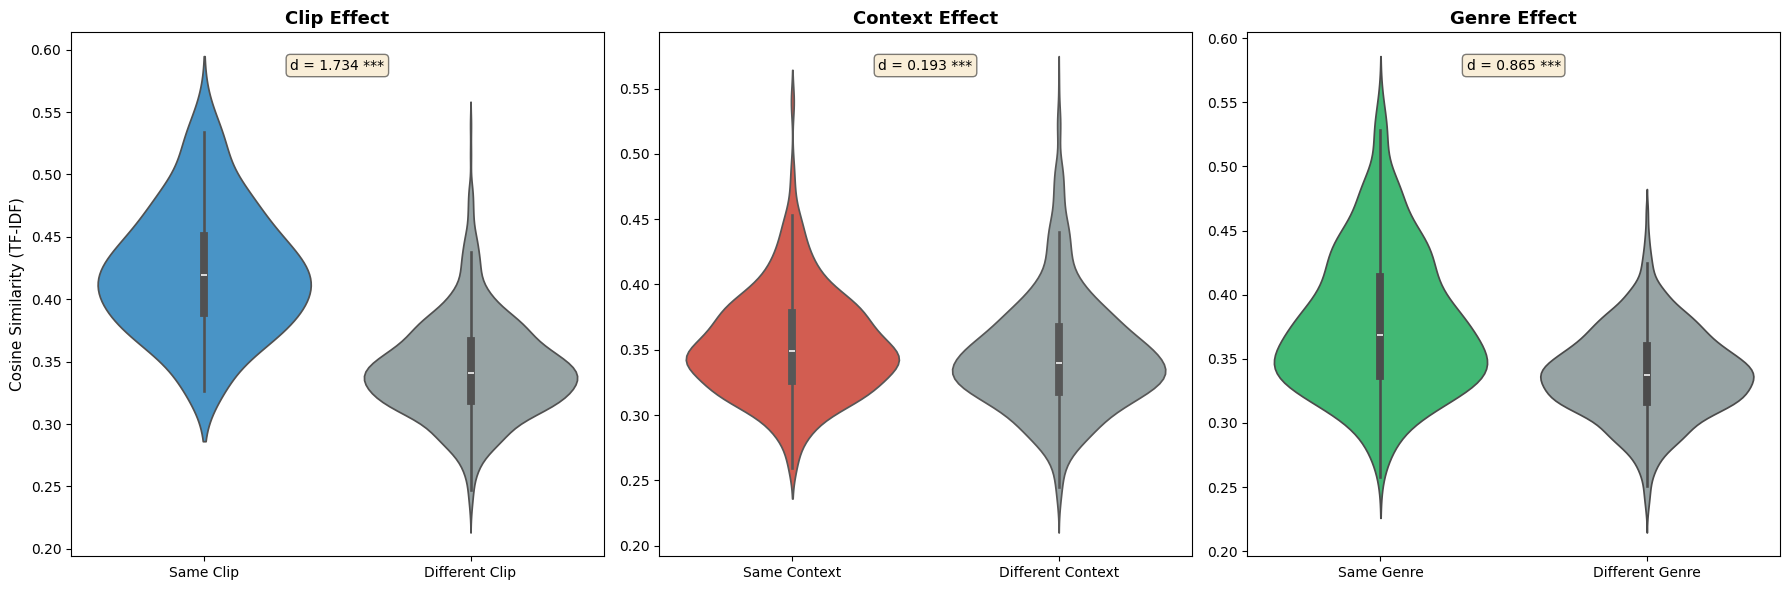

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Clip comparison
clip_data = sim_df_docs.copy()
clip_data['clip_label'] = clip_data['same_clip'].map({True: 'Same Clip', False: 'Different Clip'})
sns.violinplot(data=clip_data, x='clip_label', y='similarity',
               order=['Same Clip', 'Different Clip'], ax=axes[0],
               hue='clip_label', palette=['#95a5a6', '#3498db'])
axes[0].set_title('Clip Effect', fontsize=13, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Cosine Similarity (TF-IDF)', fontsize=11)
axes[0].text(0.5, 0.95, f"d = {clip_comp['d']:.3f} {clip_comp['sig']}",
             ha='center', va='top', transform=axes[0].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Context comparison
context_data = sim_df_docs.copy()
context_data['context_label'] = context_data['same_context'].map({True: 'Same Context', False: 'Different Context'})
sns.violinplot(data=context_data, x='context_label', y='similarity',
               order=['Same Context', 'Different Context'], ax=axes[1],
               hue='context_label', palette=['#e74c3c', '#95a5a6'])
axes[1].set_title('Context Effect', fontsize=13, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].text(0.5, 0.95, f"d = {context_comp['d']:.3f} {context_comp['sig']}",
             ha='center', va='top', transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Genre comparison
genre_data = sim_df_docs.copy()
genre_data['genre_label'] = genre_data['same_genre'].map({True: 'Same Genre', False: 'Different Genre'})
sns.violinplot(data=genre_data, x='genre_label', y='similarity',
               order=['Same Genre', 'Different Genre'], ax=axes[2],
               hue='genre_label', palette=['#2ecc71', '#95a5a6'])
axes[2].set_title('Genre Effect', fontsize=13, fontweight='bold')
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].text(0.5, 0.95, f"d = {genre_comp['d']:.3f} {genre_comp['sig']}",
             ha='center', va='top', transform=axes[2].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_binary_comparisons.png',
            dpi=300, bbox_inches='tight')
plt.show()

#### Factor-Specific Analyses

##### Function set-up

1. analyze_within_factor_similarity
2. analyze_pairwise_factor_comparisons
3. analyze_factor_music_vs_context
4. analyze_factor_consistency

In [10]:
def analyze_within_factor_similarity(sim_df, metadata, factor_column, factor_name):
    """
    Analyze within-factor similarity (e.g., same context/genre, different clips).

    Parameters:
    - sim_df: similarity dataframe
    - metadata: METdocs dataframe
    - factor_column: 'context_word' or 'genre_code'
    - factor_name: 'Context' or 'Genre' (for display)

    Returns:
    - DataFrame with within-factor statistics
    """
    print(f"\n1. WITHIN-{factor_name.upper()} SIMILARITY")
    print("-" * 70)

    if factor_name == 'Context':
        print("When different music is heard with the same context, how similar are thoughts?")
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        print("When different clips from the same genre are heard, how similar are thoughts?")
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    within_results = []
    factors = metadata[factor_column].unique()

    for factor in factors:
        # Get similarity for same factor, different clips
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_column.split("_")[0]}_i'] == factor) &
            (sim_df[f'{factor_column.split("_")[0]}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            within_results.append({
                factor_name.lower(): factor,
                'mean': factor_sims.mean(),
                'std': factor_sims.std(),
                'n': len(factor_sims),
                'cv': factor_sims.std() / factor_sims.mean()
            })

            print(f"\n{factor.upper()}:")
            print(f"  Mean similarity: {factor_sims.mean():.4f}")
            print(f"  SD: {factor_sims.std():.4f}")
            print(f"  CV: {factor_sims.std() / factor_sims.mean():.4f}")
            print(f"  N pairs: {len(factor_sims)}")

    within_df = pd.DataFrame(within_results).sort_values('mean', ascending=False)

    print(f"\n{'-'*70}")
    print(f"RANKING: {factor_name}s by Thought Convergence")
    print("-"*70)
    for i, row in within_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: M={row['mean']:.4f} (CV={row['cv']:.4f})")

    print(f"\n→ {within_df.iloc[0][factor_name.lower()].upper()} produces MOST similar thoughts")
    print(f"→ {within_df.iloc[-1][factor_name.lower()].upper()} produces MOST DIVERSE thoughts")

    return within_df


# ----------------------------------------------------------------------------
def analyze_pairwise_factor_comparisons(sim_df, metadata, factor_column, factor_name, within_df):
    """
    Pairwise comparisons between different factors.

    Returns:
    - DataFrame with pairwise comparison statistics
    """
    print(f"\n\n2. PAIRWISE {factor_name.upper()} COMPARISONS")
    print("-" * 70)

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    factor_pairs = []
    factors_list = list(metadata[factor_column].unique())
    factor_key = factor_column.split('_')[0]

    for i, factor1 in enumerate(factors_list):
        for factor2 in factors_list[i+1:]:
            factor1_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor1) &
                (sim_df[f'{factor_key}_j'] == factor1)
            ]['similarity']

            factor2_sims = sim_df[
                condition_filter &
                (sim_df[f'{factor_key}_i'] == factor2) &
                (sim_df[f'{factor_key}_j'] == factor2)
            ]['similarity']

            if len(factor1_sims) > 0 and len(factor2_sims) > 0:
                t_stat, p_val = stats.ttest_ind(factor1_sims, factor2_sims)
                pooled_std = np.sqrt((factor1_sims.std()**2 + factor2_sims.std()**2) / 2)
                effect_size = (factor1_sims.mean() - factor2_sims.mean()) / pooled_std

                if p_val < 0.001:
                    sig = "***"
                elif p_val < 0.01:
                    sig = "**"
                elif p_val < 0.05:
                    sig = "*"
                else:
                    sig = "n.s."

                factor_pairs.append({
                    f'{factor_name.lower()}1': factor1,
                    f'{factor_name.lower()}2': factor2,
                    'mean1': factor1_sims.mean(),
                    'mean2': factor2_sims.mean(),
                    'difference': factor1_sims.mean() - factor2_sims.mean(),
                    't': t_stat,
                    'p': p_val,
                    'd': effect_size,
                    'sig': sig
                })

    pairs_df = pd.DataFrame(factor_pairs).sort_values('d', key=abs, ascending=False)

    print(f"\nSignificant differences between {factor_name.lower()}s:")
    for _, row in pairs_df.iterrows():
        if row['sig'] != 'n.s.':
            print(f"\n{row[f'{factor_name.lower()}1'].upper()} vs {row[f'{factor_name.lower()}2'].upper()}:")
            print(f"  Means: {row['mean1']:.4f} vs {row['mean2']:.4f}")
            print(f"  Difference: {row['difference']:.4f}")
            print(f"  t = {row['t']:.3f}, p = {row['p']:.4f} {row['sig']}, d = {row['d']:.3f}")

    return pairs_df


# ----------------------------------------------------------------------------
def analyze_factor_music_vs_context(sim_df, metadata, factor_column, factor_name):
    """
    Compare music-driven vs. context-driven effects within each factor level.

    For Context: Uses OR logic for music-driven (captures cross-context comparisons)
    For Genre: Uses AND logic for both (pure within-genre comparisons)

    Returns:
    - DataFrame with comparison statistics
    """
    print(f"\n\n3. {factor_name.upper()}-SPECIFIC COMPARISON: Music vs. Context Effects")
    print("-" * 70)
    print("For each {}, comparing:".format(factor_name.lower()))
    print("  - Music-driven similarity: same clip heard in DIFFERENT contexts")
    print("  - Context-driven similarity: DIFFERENT clips heard in the same context")

    if factor_name == 'Context':
        print("\nNote: Music-driven uses OR logic (at least one doc from target context)")
        print("      Context-driven uses AND logic (both docs from target context)\n")
    else:
        print(f"\nNote: Music-driven uses AND logic (both docs from target {factor_name.lower()})")
        print(f"      Context-driven uses AND logic (both docs from target {factor_name.lower()})\n")

    moderator_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    for factor in factors:
        # MUSIC-DRIVEN: Same clip, different contexts
        if factor_name == 'Context':
            # Use OR logic for context: captures cross-context comparisons
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            # Use AND logic for genre: pure within-genre
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # CONTEXT-DRIVEN: Different clips, same context
        # Always use AND logic: pure within-factor
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            # Statistical comparison
            t_stat, p_val = stats.ttest_ind(music_sims, context_sims)
            pooled_std = np.sqrt((music_sims.std()**2 + context_sims.std()**2) / 2)
            effect_size = (music_sims.mean() - context_sims.mean()) / pooled_std

            # Significance marker
            if p_val < 0.001:
                sig = "***"
            elif p_val < 0.01:
                sig = "**"
            elif p_val < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            moderator_results.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'difference': music_sims.mean() - context_sims.mean(),
                'effect_size': effect_size,
                't': t_stat,
                'p': p_val,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven: M={music_sims.mean():.4f}, SD={music_sims.std():.4f} (N={len(music_sims)})")
            if factor_name == 'Context':
                print(f"    (Same clip involving {factor} vs. other contexts)")
            else:
                print(f"    (Same clip, different contexts, both {factor})")
            print(f"  Context-driven: M={context_sims.mean():.4f}, SD={context_sims.std():.4f} (N={len(context_sims)})")
            print(f"    (Different clips both within {factor})")
            print(f"  Difference: {music_sims.mean() - context_sims.mean():.4f}")
            print(f"  t({len(music_sims) + len(context_sims) - 2}) = {t_stat:.3f}, p = {p_val:.4f} {sig}")
            print(f"  Cohen's d = {effect_size:.3f}")

            if sig != "n.s.":
                if music_sims.mean() > context_sims.mean():
                    print(f"  → In {factor}, MUSIC drives similarity MORE than context")
                else:
                    print(f"  → In {factor}, CONTEXT drives similarity MORE than music")
            else:
                print(f"  → In {factor}, music and context have comparable effects")

    # Summary
    if len(moderator_results) > 0:
        moderator_df = pd.DataFrame(moderator_results)

        print(f"\n{'-'*70}")
        print(f"{factor_name.upper()}-SPECIFIC SUMMARY")
        print("-"*70)

        # Count patterns
        music_dominant = moderator_df[
            (moderator_df['difference'] > 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        context_dominant = moderator_df[
            (moderator_df['difference'] < 0) &
            (moderator_df['sig'] != 'n.s.')
        ]
        no_difference = moderator_df[moderator_df['sig'] == 'n.s.']

        print(f"\nAcross {len(moderator_df)} {factor_name.lower()}s:")
        print(f"  Music-dominant: {len(music_dominant)} {factor_name.lower()}s")
        if len(music_dominant) > 0:
            print(f"    {', '.join(music_dominant[factor_name.lower()].values)}")

        print(f"  Context-dominant: {len(context_dominant)} {factor_name.lower()}s")
        if len(context_dominant) > 0:
            print(f"    {', '.join(context_dominant[factor_name.lower()].values)}")

        print(f"  No significant difference: {len(no_difference)} {factor_name.lower()}s")
        if len(no_difference) > 0:
            print(f"    {', '.join(no_difference[factor_name.lower()].values)}")

        # Mean effect size
        print(f"\n  Mean effect size (|d|): {moderator_df['effect_size'].abs().mean():.3f}")
        print(f"  Range: {moderator_df['effect_size'].min():.3f} to {moderator_df['effect_size'].max():.3f}")

        # Heterogeneity test
        print(f"\n{'-'*70}")
        print(f"HETEROGENEITY TEST: Do music vs. context effects vary by {factor_name.lower()}?")
        print("-"*70)

        if len(moderator_df) >= 3:
            effect_size_var = moderator_df['effect_size'].var()
            effect_size_range = (moderator_df['effect_size'].max() -
                                moderator_df['effect_size'].min())

            print(f"Effect size variance: {effect_size_var:.4f}")
            print(f"Effect size range: {effect_size_range:.4f}")

            if effect_size_range > 0.5:
                print(f"\n→ SUBSTANTIAL HETEROGENEITY: Music vs. context effects differ notably by {factor_name.lower()}")
            elif effect_size_range > 0.3:
                print(f"\n→ MODERATE HETEROGENEITY: Some variation in music vs. context effects by {factor_name.lower()}")
            else:
                print(f"\n→ MINIMAL HETEROGENEITY: Music vs. context effects are relatively consistent across {factor_name.lower()}s")

        # For genre, add ANOVA interaction test
        if factor_name == 'Genre' and len(moderator_df) >= 2:
            print(f"\n{'-'*70}")
            print(f"INTERACTION TEST: {factor_name} × Factor (Music vs. Context)")
            print("-"*70)

            # Prepare data for 2-way ANOVA
            all_comparisons = []
            factor_key = factor_column.split('_')[0]

            for _, row in moderator_df.iterrows():
                # Music condition
                music_data = sim_df[
                    (sim_df['condition'] == 'same_clip_diff_context') &
                    (sim_df[f'{factor_key}_i'] == row[factor_name.lower()]) &
                    (sim_df[f'{factor_key}_j'] == row[factor_name.lower()])
                ]['similarity'].values

                for val in music_data:
                    all_comparisons.append({
                        factor_name.lower(): row[factor_name.lower()],
                        'factor': 'music',
                        'similarity': val
                    })

                # Context condition
                context_data = sim_df[
                    (sim_df['condition'] == 'diff_clip_same_context') &
                    (sim_df[f'{factor_key}_i'] == row[factor_name.lower()]) &
                    (sim_df[f'{factor_key}_j'] == row[factor_name.lower()])
                ]['similarity'].values

                for val in context_data:
                    all_comparisons.append({
                        factor_name.lower(): row[factor_name.lower()],
                        'factor': 'context',
                        'similarity': val
                    })

            if len(all_comparisons) > 0:
                comparison_df = pd.DataFrame(all_comparisons)

                try:
                    import statsmodels.api as sm
                    from statsmodels.formula.api import ols

                    formula = f'similarity ~ C({factor_name.lower()}) * C(factor)'
                    model = ols(formula, data=comparison_df).fit()
                    anova_table = sm.stats.anova_lm(model, typ=2)

                    print("\nTwo-Way ANOVA Results:")
                    print(anova_table)

                    # Extract interaction p-value
                    interaction_p = anova_table.loc[f'C({factor_name.lower()}):C(factor)', 'PR(>F)']
                    interaction_f = anova_table.loc[f'C({factor_name.lower()}):C(factor)', 'F']

                    print(f"\nInteraction effect ({factor_name} × Factor): F = {interaction_f:.3f}, p = {interaction_p:.4f}")

                    if interaction_p < 0.001:
                        print(f"→ STRONG INTERACTION: Music vs. context effects vary SIGNIFICANTLY by {factor_name.lower()} ***")
                    elif interaction_p < 0.01:
                        print(f"→ SIGNIFICANT INTERACTION: Music vs. context effects vary by {factor_name.lower()} **")
                    elif interaction_p < 0.05:
                        print(f"→ MODERATE INTERACTION: Music vs. context effects vary by {factor_name.lower()} *")
                    else:
                        print(f"→ NO SIGNIFICANT INTERACTION: Music vs. context effects are consistent across {factor_name.lower()}s")

                except ImportError:
                    print("statsmodels not available - using descriptive heterogeneity measures only")
                except Exception as e:
                    print(f"Could not compute interaction ANOVA: {e}")

        return moderator_df

    return pd.DataFrame()


# ----------------------------------------------------------------------------
def analyze_factor_consistency(sim_df, metadata, factor_column, factor_name):
    """
    Analyze consistency (CV) within each factor and compare music vs. context consistency.

    Returns:
    - Tuple of (within_consistency_df, music_vs_context_consistency_df)
    """
    print(f"\n{'-'*70}")
    print(f"WITHIN-{factor_name.upper()} CONSISTENCY ANALYSIS")
    print("-"*70)
    print(f"Testing which {factor_name.lower()}s produce more consistent/convergent thought patterns")
    print(f"Lower CV = more convergent/consistent thoughts within that {factor_name.lower()}\n")

    # Calculate CV for each factor
    consistency_results = []
    factors = metadata[factor_column].unique()
    factor_key = factor_column.split('_')[0]

    if factor_name == 'Context':
        condition_filter = sim_df['condition'] == 'diff_clip_same_context'
    else:  # Genre
        condition_filter = (sim_df['same_genre'] == True) & (sim_df['same_clip'] == False)

    for factor in factors:
        factor_sims = sim_df[
            condition_filter &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        ]['similarity']

        if len(factor_sims) > 0:
            mean_sim = factor_sims.mean()
            std_sim = factor_sims.std()
            cv = std_sim / mean_sim

            consistency_results.append({
                factor_name.lower(): factor,
                'mean': mean_sim,
                'std': std_sim,
                'cv': cv,
                'n': len(factor_sims)
            })

            print(f"{factor.upper()}:")
            print(f"  Mean similarity: {mean_sim:.4f}")
            print(f"  SD: {std_sim:.4f}")
            print(f"  CV: {cv:.4f} (lower = more consistent)")
            print(f"  N pairs: {len(factor_sims)}\n")

    consistency_df = pd.DataFrame(consistency_results).sort_values('cv')

    print(f"\n{factor_name.upper()} CONSISTENCY RANKING (most to least consistent)")
    print("-"*70)
    for i, row in consistency_df.iterrows():
        print(f"  {i+1}. {row[factor_name.lower()].upper()}: CV={row['cv']:.4f}")

    print(f"\n→ {consistency_df.iloc[0][factor_name.lower()].upper()} produces MOST CONSISTENT thoughts")
    print(f"→ {consistency_df.iloc[-1][factor_name.lower()].upper()} produces MOST VARIABLE thoughts")

    # Music vs. Context consistency comparison
    print(f"\n\nCONSISTENCY COMPARISON: Music vs. Context Effects Within {factor_name}s")
    print("-"*70)
    print("Using Levene's test to assess if variance (consistency) differs significantly")
    print(f"between music-driven and context-driven conditions within each {factor_name.lower()}.\n")

    music_vs_context_consistency = []

    for factor in factors:
        # Music-driven
        if factor_name == 'Context':
            # Use OR logic for context
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                ((sim_df[f'{factor_key}_i'] == factor) | (sim_df[f'{factor_key}_j'] == factor))
            )
        else:
            # Use AND logic for genre
            music_filter = (
                (sim_df['condition'] == 'same_clip_diff_context') &
                (sim_df[f'{factor_key}_i'] == factor) &
                (sim_df[f'{factor_key}_j'] == factor)
            )

        music_sims = sim_df[music_filter]['similarity']

        # Context-driven (always AND logic)
        context_filter = (
            (sim_df['condition'] == 'diff_clip_same_context') &
            (sim_df[f'{factor_key}_i'] == factor) &
            (sim_df[f'{factor_key}_j'] == factor)
        )
        context_sims = sim_df[context_filter]['similarity']

        if len(music_sims) > 0 and len(context_sims) > 0:
            music_cv = music_sims.std() / music_sims.mean()
            context_cv = context_sims.std() / context_sims.mean()
            cv_difference = music_cv - context_cv

            # Levene's test for equal variances
            from scipy.stats import levene
            levene_stat, levene_p = levene(music_sims, context_sims)

            # Determine significance
            if levene_p < 0.001:
                sig = "***"
            elif levene_p < 0.01:
                sig = "**"
            elif levene_p < 0.05:
                sig = "*"
            else:
                sig = "n.s."

            music_vs_context_consistency.append({
                factor_name.lower(): factor,
                'music_mean': music_sims.mean(),
                'music_sd': music_sims.std(),
                'music_cv': music_cv,
                'context_mean': context_sims.mean(),
                'context_sd': context_sims.std(),
                'context_cv': context_cv,
                'cv_difference': cv_difference,
                'levene_stat': levene_stat,
                'levene_p': levene_p,
                'sig': sig,
                'n_music': len(music_sims),
                'n_context': len(context_sims)
            })

            print(f"\n{factor.upper()}:")
            print(f"  Music-driven:")
            print(f"    M={music_sims.mean():.4f}, SD={music_sims.std():.4f}, CV={music_cv:.4f} (N={len(music_sims)})")
            if factor_name == 'Context':
                print(f"    (Same clip involving {factor} vs. other contexts)")
            else:
                print(f"    (Same clip, different contexts, both {factor})")
            print(f"  Context-driven:")
            print(f"    M={context_sims.mean():.4f}, SD={context_sims.std():.4f}, CV={context_cv:.4f} (N={len(context_sims)})")
            print(f"    (Different clips both within {factor})")
            print(f"  CV Difference (Music - Context): {cv_difference:.4f}")
            print(f"  Levene's test: F={levene_stat:.3f}, p={levene_p:.4f} {sig}")

            # Only conclude if Levene's test is significant
            if levene_p < 0.05:
                if music_cv < context_cv:
                    print(f"  → In {factor}, MUSIC creates SIGNIFICANTLY more consistent patterns")
                else:
                    print(f"  → In {factor}, CONTEXT creates SIGNIFICANTLY more consistent patterns")
            else:
                print(f"  → In {factor}, consistency does NOT differ significantly (despite CV difference)")

    music_vs_context_df = pd.DataFrame(music_vs_context_consistency)

    # Summary
    print(f"\n{'-'*70}")
    print("CONSISTENCY COMPARISON SUMMARY")
    print("-"*70)

    if len(music_vs_context_df) > 0:
        significant_diffs = music_vs_context_df[music_vs_context_df['levene_p'] < 0.05]

        print(f"\nAcross {len(music_vs_context_df)} {factor_name.lower()}s:")
        print(f"  Significant consistency differences: {len(significant_diffs)}/{len(music_vs_context_df)}")

        if len(significant_diffs) > 0:
            music_more_consistent = significant_diffs[significant_diffs['cv_difference'] < 0]
            context_more_consistent = significant_diffs[significant_diffs['cv_difference'] > 0]

            if len(music_more_consistent) > 0:
                print(f"\n  {factor_name}s where MUSIC is significantly more consistent:")
                for _, row in music_more_consistent.iterrows():
                    print(f"    - {row[factor_name.lower()].upper()}: CV diff = {row['cv_difference']:.4f}, p = {row['levene_p']:.4f}")

            if len(context_more_consistent) > 0:
                print(f"\n  {factor_name}s where CONTEXT is significantly more consistent:")
                for _, row in context_more_consistent.iterrows():
                    print(f"    - {row[factor_name.lower()].upper()}: CV diff = {row['cv_difference']:.4f}, p = {row['levene_p']:.4f}")
        else:
            print(f"  No {factor_name.lower()}s show significant consistency differences")

        # Overall pattern
        mean_cv_diff = music_vs_context_df['cv_difference'].mean()
        print(f"\n  Mean CV difference (Music - Context): {mean_cv_diff:.4f}")

        # Count significant effects in each direction
        sig_music_more_consistent = len(music_vs_context_df[
            (music_vs_context_df['levene_p'] < 0.05) &
            (music_vs_context_df['cv_difference'] < 0)
        ])
        sig_context_more_consistent = len(music_vs_context_df[
            (music_vs_context_df['levene_p'] < 0.05) &
            (music_vs_context_df['cv_difference'] > 0)
        ])

        if sig_music_more_consistent > sig_context_more_consistent:
           print(f"  → Overall pattern: Music creates significantly more consistent patterns")
           print(f"    (in {sig_music_more_consistent}/{len(significant_diffs)} significant cases)")
        elif sig_context_more_consistent > sig_music_more_consistent:
            print(f"  → Overall pattern: Context creates significantly more consistent patterns")
            print(f"    (in {sig_context_more_consistent}/{len(significant_diffs)} significant cases)")
        else:
           print(f"  → No clear overall pattern in consistency differences")
           print(f"    NOTE: Mean CV difference of {mean_cv_diff:.4f} is descriptive only")

        # Heterogeneity test for context
        if factor_name == 'Context' and len(music_vs_context_df) >= 3:
            print(f"\n{'-'*70}")
            print("HETEROGENEITY TEST: Do consistency patterns vary by context?")
            print("-"*70)

            cv_diff_var = music_vs_context_df['cv_difference'].var()
            cv_diff_range = (music_vs_context_df['cv_difference'].max() -
                            music_vs_context_df['cv_difference'].min())

            print(f"CV difference variance: {cv_diff_var:.4f}")
            print(f"CV difference range: {cv_diff_range:.4f}")

            if cv_diff_range > 0.15:
                print("\n→ SUBSTANTIAL HETEROGENEITY: Consistency patterns differ notably across contexts")
            elif cv_diff_range > 0.10:
                print("\n→ MODERATE HETEROGENEITY: Some variation in consistency patterns across contexts")
            else:
                print("\n→ MINIMAL HETEROGENEITY: Consistency patterns are relatively uniform across contexts")

    return consistency_df, music_vs_context_df

##### Factor-Specific (Context & Genre) Analyses _execution_

In [11]:
# ----------------------------------------------------------------------------
# CONTEXT ANALYSIS
# ----------------------------------------------------------------------------

print("\n" + "="*70)
print("SPECIFIC CONTEXT ANALYSIS")
print("="*70)
print("Testing whether specific contexts (bar, concert, movie, videogame)")
print("produce distinctive thought patterns\n")

# Add context labels to similarity dataframe
doc_contexts = METdocs['context_word'].values
sim_df_docs['context_i'] = sim_df_docs['doc_i'].map(lambda x: doc_contexts[x])
sim_df_docs['context_j'] = sim_df_docs['doc_j'].map(lambda x: doc_contexts[x])

# Run all context analyses
within_context_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'context_word', 'Context', within_context_df
)

context_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

context_consistency_df, context_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'context_word', 'Context'
)

# Save context results
print("\n→ Saving context results...")
within_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_within_context_analysis.csv',
    index=False
)
context_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_context_pairwise_comparisons.csv',
    index=False
)
context_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_context_consistency.csv',
    index=False
)
if len(context_moderator_df) > 0:
    context_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_context_moderator_music_vs_context.csv',
        index=False
    )
if len(context_consistency_comparison_df) > 0:
    context_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_context_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Context analysis complete and results saved")


# ----------------------------------------------------------------------------
# GENRE ANALYSIS
# ----------------------------------------------------------------------------

print("\n\n" + "="*70)
print("SPECIFIC GENRE ANALYSIS")
print("="*70)
print("Testing whether specific genres (80s, Electronic, Jazz, Metal)")
print("produce distinctive thought patterns\n")

# Add genre labels to similarity dataframe if not already present
if 'genre_i' not in sim_df_docs.columns:
    doc_genres = METdocs['genre_code'].values
    sim_df_docs['genre_i'] = sim_df_docs['doc_i'].map(lambda x: doc_genres[x])
    sim_df_docs['genre_j'] = sim_df_docs['doc_j'].map(lambda x: doc_genres[x])

# Run all genre analyses
within_genre_df = analyze_within_factor_similarity(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_pairs_df = analyze_pairwise_factor_comparisons(
    sim_df_docs, METdocs, 'genre_code', 'Genre', within_genre_df
)

genre_moderator_df = analyze_factor_music_vs_context(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

genre_consistency_df, genre_consistency_comparison_df = analyze_factor_consistency(
    sim_df_docs, METdocs, 'genre_code', 'Genre'
)

# Save genre results
print("\n→ Saving genre results...")
within_genre_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_within_genre_analysis.csv',
    index=False
)
genre_pairs_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_genre_pairwise_comparisons.csv',
    index=False
)
genre_consistency_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_genre_consistency.csv',
    index=False
)
if len(genre_moderator_df) > 0:
    genre_moderator_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_genre_moderator_music_vs_context.csv',
        index=False
    )
if len(genre_consistency_comparison_df) > 0:
    genre_consistency_comparison_df.to_csv(
        '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_genre_music_vs_context_consistency.csv',
        index=False
    )
print("✓ Genre analysis complete and results saved")


# ----------------------------------------------------------------------------
# GENRE × CONTEXT INTERACTION
# ----------------------------------------------------------------------------

print("\n\n" + "="*70)
print("GENRE × CONTEXT INTERACTION")
print("="*70)
print("Do certain genres work better with certain contexts?\n")

genre_context_interaction = []
genres = METdocs['genre_code'].unique()
contexts = METdocs['context_word'].unique()

for genre in genres:
    for context in contexts:
        # Get similarity when this specific genre-context pair matches
        specific_sims = sim_df_docs[
            (sim_df_docs['condition'] == 'diff_clip_same_context') &
            (sim_df_docs['genre_i'] == genre) &
            (sim_df_docs['context_i'] == context)
        ]['similarity']

        if len(specific_sims) > 0:
            genre_context_interaction.append({
                'genre': genre,
                'context': context,
                'mean': specific_sims.mean(),
                'std': specific_sims.std(),
                'n': len(specific_sims)
            })

genre_context_df = pd.DataFrame(genre_context_interaction)

# Find best and worst combinations
print("Top 5 Genre-Context combinations (highest similarity):")
top_combos = genre_context_df.nlargest(5, 'mean')
for idx, row in top_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

print("\nBottom 5 Genre-Context combinations (lowest similarity):")
bottom_combos = genre_context_df.nsmallest(5, 'mean')
for idx, row in bottom_combos.iterrows():
    print(f"  {row['genre'].upper()} + {row['context'].upper()}: M={row['mean']:.4f}")

# Save results
genre_context_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/METdocs_genre_context_interaction.csv',
    index=False
)
print("\n✓ Genre × Context interaction complete and results saved")


# ----------------------------------------------------------------------------
# FINAL SUMMARY
# ----------------------------------------------------------------------------

print("\n" + "="*70)
print("OVERALL CONSISTENCY COMPARISON")
print("="*70)

print("\nGENRE CONSISTENCY:")
print(f"  Most consistent: {genre_consistency_df.iloc[0]['genre'].upper()} (CV={genre_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {genre_consistency_df.iloc[-1]['genre'].upper()} (CV={genre_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {genre_consistency_df['cv'].max() - genre_consistency_df['cv'].min():.4f}")

print("\nCONTEXT CONSISTENCY:")
print(f"  Most consistent: {context_consistency_df.iloc[0]['context'].upper()} (CV={context_consistency_df.iloc[0]['cv']:.4f})")
print(f"  Least consistent: {context_consistency_df.iloc[-1]['context'].upper()} (CV={context_consistency_df.iloc[-1]['cv']:.4f})")
print(f"  Range: {context_consistency_df['cv'].max() - context_consistency_df['cv'].min():.4f}")

# Direct comparison - WITH PROPER STATISTICAL TEST
genre_mean_cv = genre_consistency_df['cv'].mean()
context_mean_cv = context_consistency_df['cv'].mean()

print(f"\nOVERALL AVERAGE CV (Descriptive Comparison):")
print(f"  Genre: {genre_mean_cv:.4f}")
print(f"  Context: {context_mean_cv:.4f}")
print(f"  Difference: {abs(genre_mean_cv - context_mean_cv):.4f}")

# Add statistical test
if len(genre_consistency_df) >= 2 and len(context_consistency_df) >= 2:
    from scipy import stats
    t_stat, p_val = stats.ttest_ind(
        genre_consistency_df['cv'],
        context_consistency_df['cv']
    )

    if p_val < 0.05:
        if genre_mean_cv < context_mean_cv:
            print(f"  → Genres produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
        else:
            print(f"  → Contexts produce SIGNIFICANTLY more consistent thoughts (t={t_stat:.2f}, p={p_val:.4f})")
    else:
        print(f"  → No significant difference in consistency between genres and contexts")
        print(f"    (t={t_stat:.2f}, p={p_val:.4f})")
        print(f"    NOTE: Descriptive difference observed but not statistically significant")
else:
    print(f"  NOTE: This is a DESCRIPTIVE comparison only (insufficient data for statistical test)")
    print(f"        Interpret with caution - difference may not be meaningful")


print("\n" + "="*70)
print("FACTOR-SPECIFIC ANALYSES COMPLETE")
print("="*70)
print("Completed:")
print("  ✓ Context: Within-factor, pairwise, music vs. context, consistency")
print("  ✓ Genre: Within-factor, pairwise, music vs. context, consistency")
print("  ✓ Genre × Context interaction")
print("  ✓ All results saved to CSV files")
print("="*70)


SPECIFIC CONTEXT ANALYSIS
Testing whether specific contexts (bar, concert, movie, videogame)
produce distinctive thought patterns


1. WITHIN-CONTEXT SIMILARITY
----------------------------------------------------------------------
When different music is heard with the same context, how similar are thoughts?

BAR :
  Mean similarity: 0.3686
  SD: 0.0355
  CV: 0.0964
  N pairs: 120

CONCERT :
  Mean similarity: 0.3582
  SD: 0.0451
  CV: 0.1260
  N pairs: 120

MOVIE:
  Mean similarity: 0.3449
  SD: 0.0382
  CV: 0.1108
  N pairs: 120

VIDEO GAME:
  Mean similarity: 0.3445
  SD: 0.0370
  CV: 0.1073
  N pairs: 120

----------------------------------------------------------------------
RANKING: Contexts by Thought Convergence
----------------------------------------------------------------------
  1. BAR : M=0.3686 (CV=0.0964)
  2. CONCERT : M=0.3582 (CV=0.1260)
  3. MOVIE: M=0.3449 (CV=0.1108)
  4. VIDEO GAME: M=0.3445 (CV=0.1073)

→ BAR  produces MOST similar thoughts
→ VIDEO GAME produc

###### Visualisations


GENERATING FACTOR-SPECIFIC VISUALIZATIONS

1. Generating within-factor comparison (Context vs. Genre)...


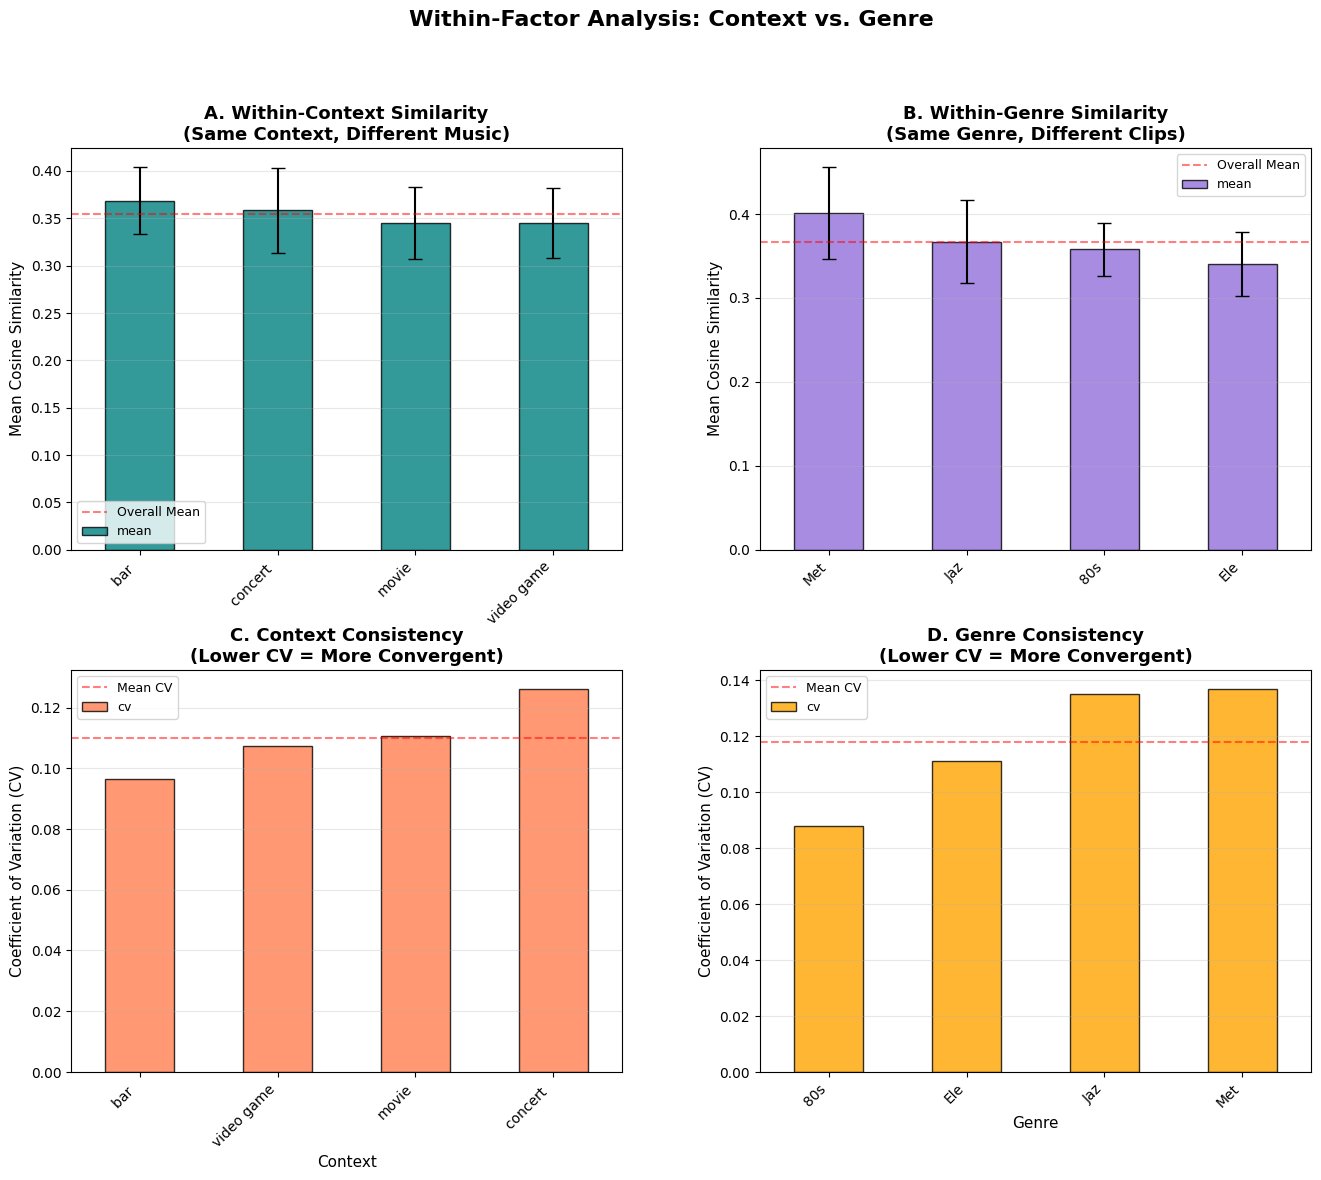

✓ Saved: TFIDF_within_factor_comparison.png

2. Generating pairwise comparison (Context vs. Genre)...


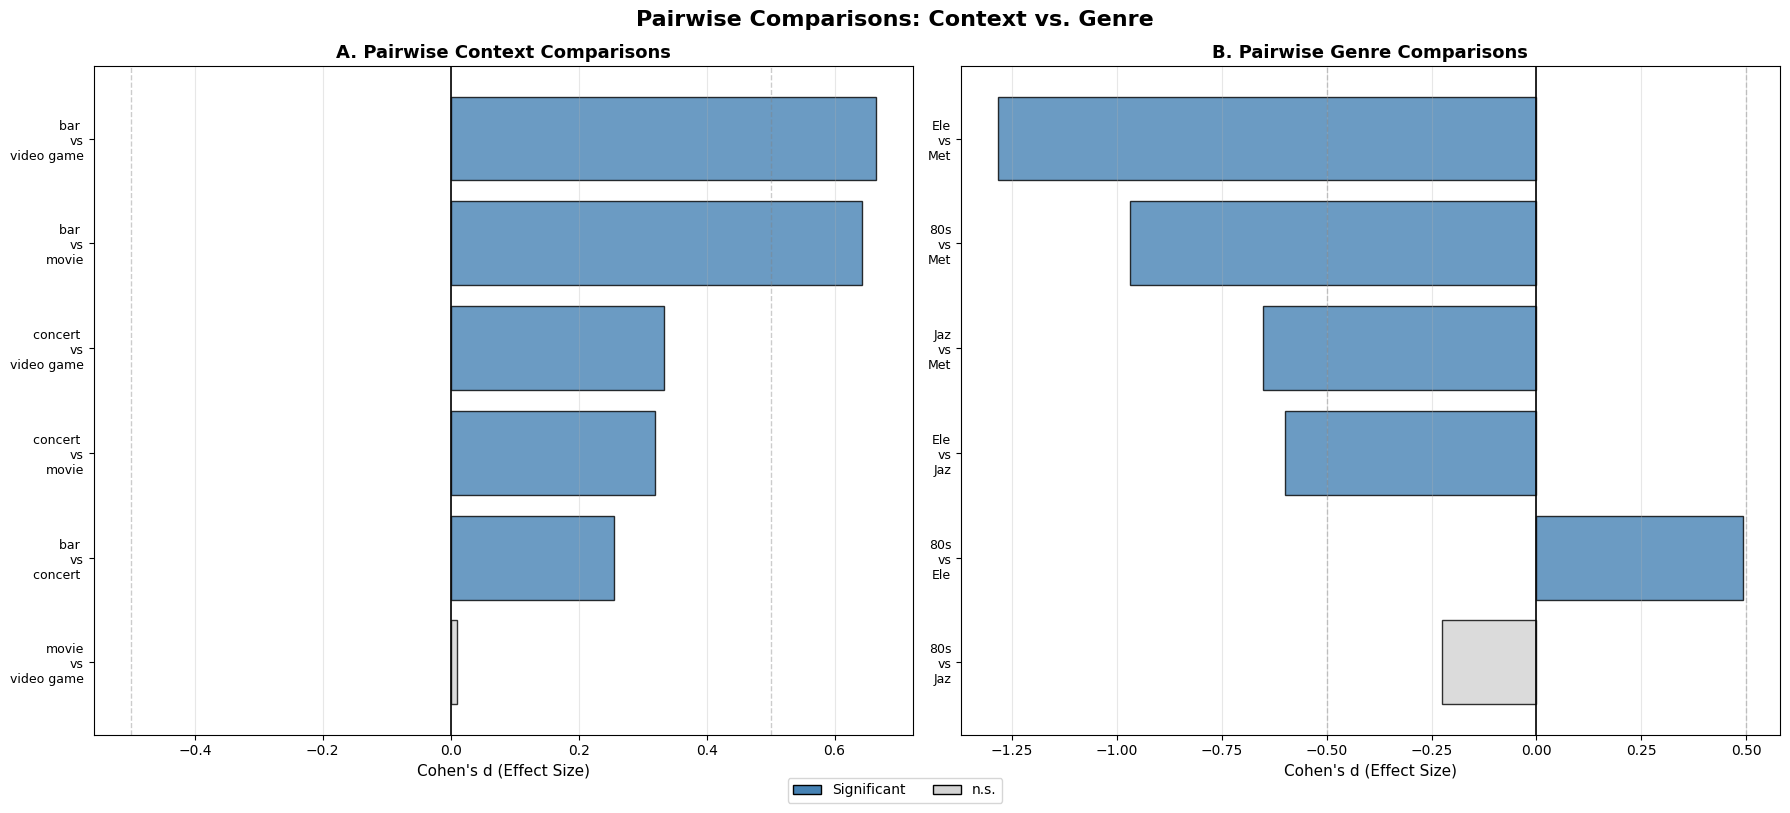

✓ Saved: TFIDF_pairwise_comparison.png

3. Generating music vs. context comparison (Context vs. Genre)...


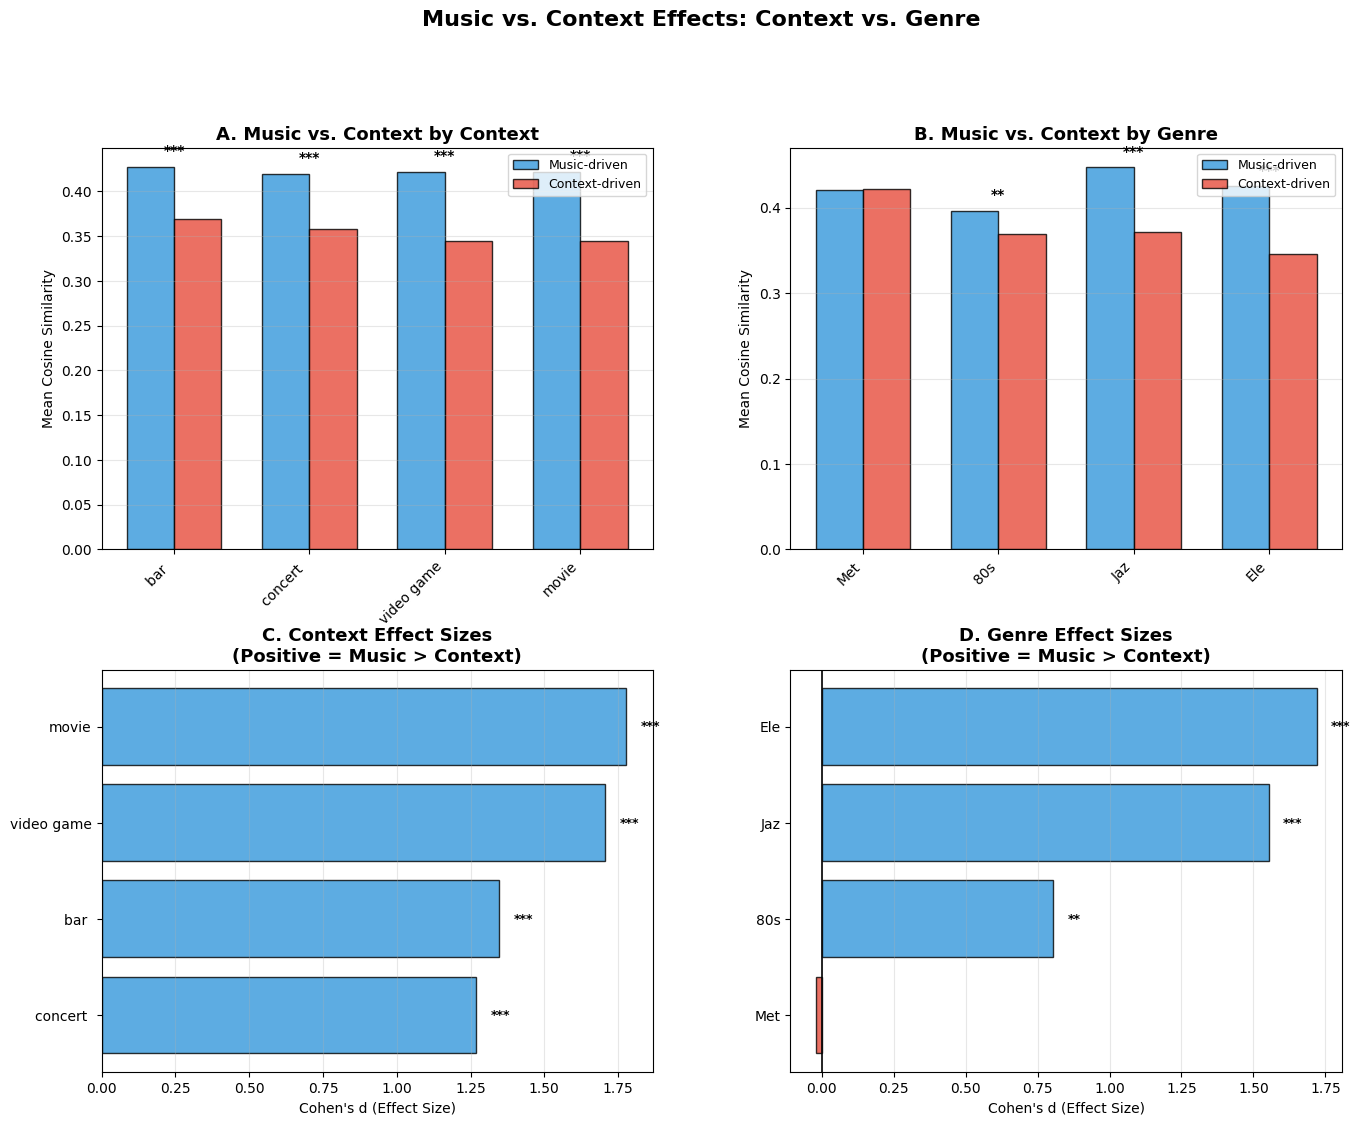

✓ Saved: TFIDF_music_vs_context_comparison.png

4. Generating consistency comparison (Context vs. Genre)...


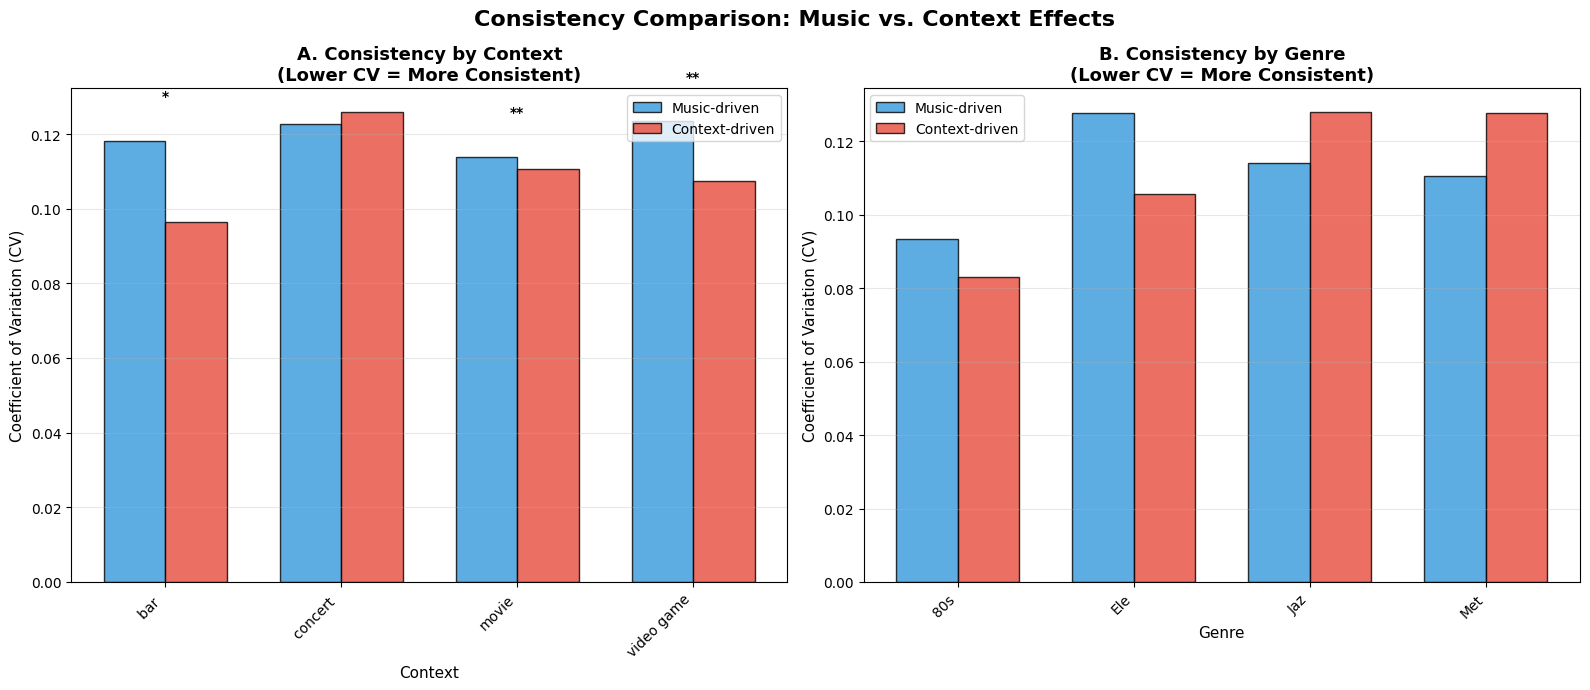

✓ Saved: TFIDF_consistency_comparison.png

5. Generating similarity matrices (Context vs. Genre)...


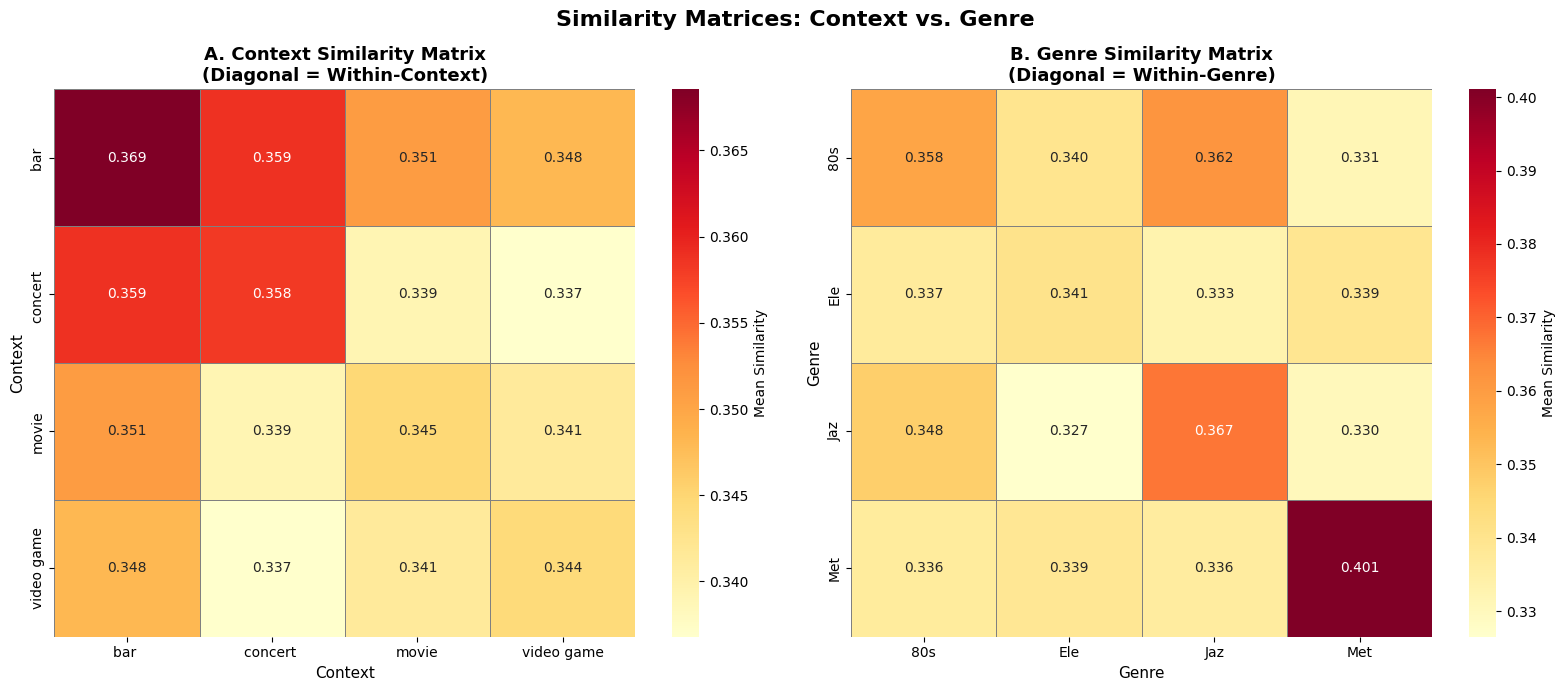

✓ Saved: TFIDF_similarity_matrices.png

6. Generating Genre × Context interaction heatmap...


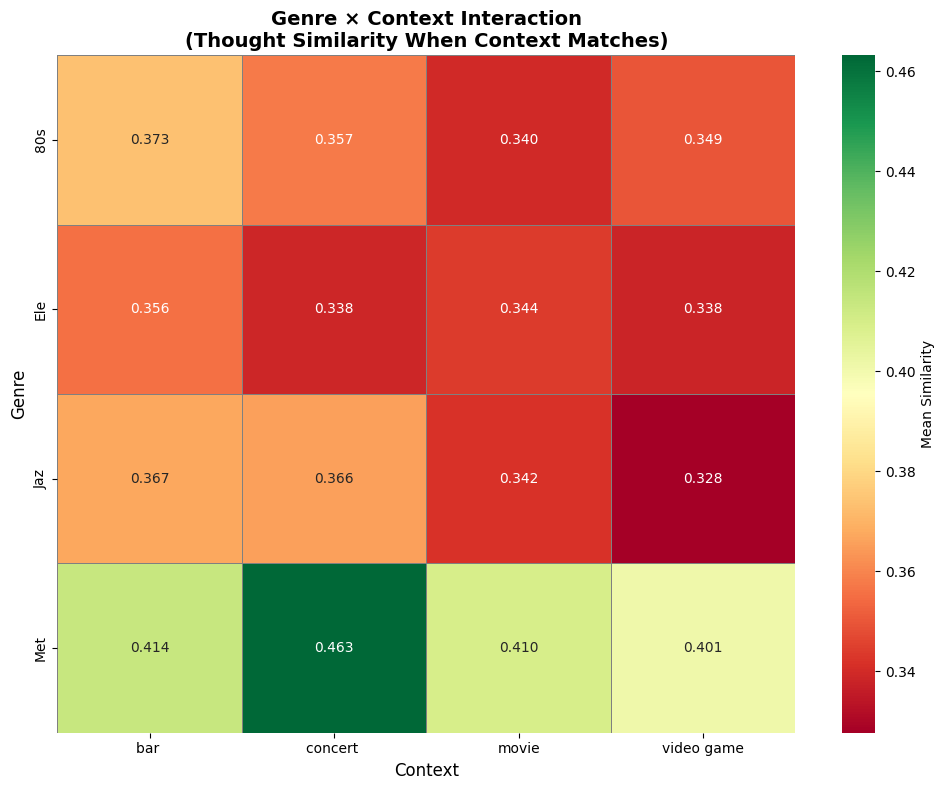

✓ Saved: TFIDF_genre_context_interaction2.png

FACTOR-SPECIFIC VISUALIZATION SUMMARY
Generated 6 comparative figures:
  Fig1: Within-factor comparison (2×2: similarity + consistency)
  Fig2: Pairwise comparison (1×2: effect sizes)
  Fig3: Music vs. context comparison (2×2: means + effect sizes)
  Fig4: Consistency comparison (1×2: music vs. context CVs)
  Fig5: Similarity matrices (1×2: context + genre heatmaps)
  Fig6: Genre × Context interaction (heatmap)

All context vs. genre comparisons are side-by-side for easy comparison!


In [12]:
print("\n" + "="*70)
print("GENERATING FACTOR-SPECIFIC VISUALIZATIONS")
print("="*70)


def create_comparative_within_factor_figure(context_df, genre_df):
    """
    Side-by-side comparison of within-factor similarity and consistency.

    Layout (2x2):
    A - Context within-factor similarity
    B - Genre within-factor similarity
    C - Context consistency (CV)
    D - Genre consistency (CV)
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    # Sort both by mean for consistent ordering
    context_sorted = context_df.sort_values('mean', ascending=False)
    genre_sorted = genre_df.sort_values('mean', ascending=False)


    # PANEL A: Context within-factor similarity
    # ------------------------------------------------------------------------
    ax_a = fig.add_subplot(gs[0, 0])

    context_sorted.plot(kind='bar', x='context', y='mean', yerr='std',
                        ax=ax_a, capsize=5, color='teal',
                        edgecolor='black', alpha=0.8, legend=False)

    ax_a.set_title('A. Within-Context Similarity\n(Same Context, Different Music)',
                   fontsize=13, fontweight='bold')
    ax_a.set_xlabel('')
    ax_a.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_a.grid(axis='y', alpha=0.3)
    ax_a.axhline(y=context_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_a.legend(fontsize=9)


    # PANEL B: Genre within-factor similarity
    # ------------------------------------------------------------------------
    ax_b = fig.add_subplot(gs[0, 1])

    genre_sorted.plot(kind='bar', x='genre', y='mean', yerr='std',
                      ax=ax_b, capsize=5, color='mediumpurple',
                      edgecolor='black', alpha=0.8, legend=False)

    ax_b.set_title('B. Within-Genre Similarity\n(Same Genre, Different Clips)',
                   fontsize=13, fontweight='bold')
    ax_b.set_xlabel('')
    ax_b.set_ylabel('Mean Cosine Similarity', fontsize=11)
    ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_b.grid(axis='y', alpha=0.3)
    ax_b.axhline(y=genre_sorted['mean'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Overall Mean')
    ax_b.legend(fontsize=9)


    # PANEL C: Context consistency (CV)
    # ------------------------------------------------------------------------
    ax_c = fig.add_subplot(gs[1, 0])

    context_cv_sorted = context_df.sort_values('cv')

    context_cv_sorted.plot(kind='bar', x='context', y='cv',
                           ax=ax_c, color='coral',
                           edgecolor='black', alpha=0.8, legend=False)

    ax_c.set_title('C. Context Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_c.set_xlabel('Context', fontsize=11)
    ax_c.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_c.set_xticklabels(context_cv_sorted['context'], rotation=45, ha='right', fontsize=10)
    ax_c.grid(axis='y', alpha=0.3)
    ax_c.axhline(y=context_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_c.legend(fontsize=9)


    # PANEL D: Genre consistency (CV)
    # ------------------------------------------------------------------------
    ax_d = fig.add_subplot(gs[1, 1])

    genre_cv_sorted = genre_df.sort_values('cv')

    genre_cv_sorted.plot(kind='bar', x='genre', y='cv',
                         ax=ax_d, color='orange',
                         edgecolor='black', alpha=0.8, legend=False)

    ax_d.set_title('D. Genre Consistency\n(Lower CV = More Convergent)',
                   fontsize=13, fontweight='bold')
    ax_d.set_xlabel('Genre', fontsize=11)
    ax_d.set_ylabel('Coefficient of Variation (CV)', fontsize=11)
    ax_d.set_xticklabels(genre_cv_sorted['genre'], rotation=45, ha='right', fontsize=10)
    ax_d.grid(axis='y', alpha=0.3)
    ax_d.axhline(y=genre_cv_sorted['cv'].mean(), color='red',
                 linestyle='--', alpha=0.5, linewidth=1.5, label='Mean CV')
    ax_d.legend(fontsize=9)

    plt.suptitle('Within-Factor Analysis: Context vs. Genre',
                fontsize=16, fontweight='bold', y=0.995)

    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_within_factor_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_within_factor_comparison.png")


# --------------------------------------------------------------------------
def create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df):
    """
    Side-by-side comparison of pairwise effect sizes.

    Layout (1x2):
    A - Context pairwise comparisons
    B - Genre pairwise comparisons
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # PANEL A: Context pairwise effect sizes
    # -------------------------------------------------------------------------
    if len(context_pairs_df) > 0:
        # Create comparison labels
        context_pairs_df['comparison'] = (context_pairs_df['context1'] + '\nvs\n' +
                                          context_pairs_df['context2'])

        # Sort by absolute effect size
        context_sorted = context_pairs_df.sort_values('d', key=abs, ascending=True)

        # Color by significance
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in context_sorted['sig']]

        axes[0].barh(range(len(context_sorted)), context_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[0].set_yticks(range(len(context_sorted)))
        axes[0].set_yticklabels(context_sorted['comparison'], fontsize=9)
        axes[0].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[0].set_title('A. Pairwise Context Comparisons',
                         fontsize=13, fontweight='bold')
        axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[0].grid(axis='x', alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[0].transAxes)

    # PANEL B: Genre pairwise effect sizes
    # -------------------------------------------------------------------------
    if len(genre_pairs_df) > 0:
        # Create comparison labels
        genre_pairs_df['comparison'] = (genre_pairs_df['genre1'] + '\nvs\n' +
                                        genre_pairs_df['genre2'])

        # Sort by absolute effect size
        genre_sorted = genre_pairs_df.sort_values('d', key=abs, ascending=True)

        # Color by significance
        colors_sig = ['steelblue' if sig != 'n.s.' else 'lightgray'
                     for sig in genre_sorted['sig']]

        axes[1].barh(range(len(genre_sorted)), genre_sorted['d'],
                    color=colors_sig, edgecolor='black', alpha=0.8)
        axes[1].set_yticks(range(len(genre_sorted)))
        axes[1].set_yticklabels(genre_sorted['comparison'], fontsize=9)
        axes[1].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
        axes[1].set_title('B. Pairwise Genre Comparisons',
                         fontsize=13, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].axvline(x=-0.5, color='gray', linestyle='--', alpha=0.4, linewidth=1)
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No pairwise comparisons available',
                    ha='center', va='center', fontsize=12, transform=axes[1].transAxes)

    # Add shared legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label='Significant'),
        Patch(facecolor='lightgray', edgecolor='black', label='n.s.')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2,
              fontsize=10, bbox_to_anchor=(0.5, -0.02))

    plt.suptitle('Pairwise Comparisons: Context vs. Genre',
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_pairwise_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_pairwise_comparison.png")


# ----------------------------------------------------------------------------
def create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df):
    """
    Side-by-side comparison of music vs. context effects by factor.

    Layout (2x2):
    A - Context: Music vs. Context means
    B - Genre: Music vs. Context means
    C - Context: Effect sizes
    D - Genre: Effect sizes
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    # PANEL A: Context music vs. context means
    # -------------------------------------------------------------------------
    ax_a = fig.add_subplot(gs[0, 0])

    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('difference')

        x = np.arange(len(context_sorted))
        width = 0.35

        ax_a.bar(x - width/2, context_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_a.bar(x + width/2, context_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_a.set_xlabel('')
        ax_a.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_a.set_title('A. Music vs. Context by Context',
                      fontsize=13, fontweight='bold')
        ax_a.set_xticks(x)
        ax_a.set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        ax_a.legend(fontsize=9, loc='upper right')
        ax_a.grid(axis='y', alpha=0.3)

        # Add significance stars
        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_a.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')
    else:
        ax_a.text(0.5, 0.5, 'No data available',
                 ha='center', va='center', fontsize=12, transform=ax_a.transAxes)

    # PANEL B: Genre music vs. context means
    # ------------------------------------------------------------------------
    ax_b = fig.add_subplot(gs[0, 1])

    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('difference')

        x = np.arange(len(genre_sorted))
        width = 0.35

        ax_b.bar(x - width/2, genre_sorted['music_mean'],
                width, label='Music-driven', color='#3498db',
                edgecolor='black', alpha=0.8)
        ax_b.bar(x + width/2, genre_sorted['context_mean'],
                width, label='Context-driven', color='#e74c3c',
                edgecolor='black', alpha=0.8)

        ax_b.set_xlabel('')
        ax_b.set_ylabel('Mean Cosine Similarity', fontsize=10)
        ax_b.set_title('B. Music vs. Context by Genre',
                      fontsize=13, fontweight='bold')
        ax_b.set_xticks(x)
        ax_b.set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        ax_b.legend(fontsize=9, loc='upper right')
        ax_b.grid(axis='y', alpha=0.3)

        # Add significance stars
        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                y_pos = max(row['music_mean'], row['context_mean']) + 0.01
                ax_b.text(i, y_pos, row['sig'], ha='center', va='bottom',
                         fontsize=10, fontweight='bold')
    else:
        ax_b.text(0.5, 0.5, 'No data available',
                 ha='center', va='center', fontsize=12, transform=ax_b.transAxes)

    # PANEL C: Context effect sizes
    # -------------------------------------------------------------------------
    ax_c = fig.add_subplot(gs[1, 0])

    if len(context_moderator_df) > 0:
        context_sorted = context_moderator_df.sort_values('effect_size')

        # Color by direction
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in context_sorted['effect_size']]

        bars = ax_c.barh(range(len(context_sorted)), context_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)

        ax_c.set_yticks(range(len(context_sorted)))
        ax_c.set_yticklabels(context_sorted['context'], fontsize=10)
        ax_c.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_c.set_title('C. Context Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_c.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_c.grid(axis='x', alpha=0.3)

        # Add significance markers
        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_c.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')
    else:
        ax_c.text(0.5, 0.5, 'No data available',
                 ha='center', va='center', fontsize=12, transform=ax_c.transAxes)

    # PANEL D: Genre effect sizes
    # -------------------------------------------------------------------------
    ax_d = fig.add_subplot(gs[1, 1])

    if len(genre_moderator_df) > 0:
        genre_sorted = genre_moderator_df.sort_values('effect_size')

        # Color by direction
        colors = ['#3498db' if d > 0 else '#e74c3c'
                 for d in genre_sorted['effect_size']]

        bars = ax_d.barh(range(len(genre_sorted)), genre_sorted['effect_size'],
                        color=colors, edgecolor='black', alpha=0.8)

        ax_d.set_yticks(range(len(genre_sorted)))
        ax_d.set_yticklabels(genre_sorted['genre'], fontsize=10)
        ax_d.set_xlabel("Cohen's d (Effect Size)", fontsize=10)
        ax_d.set_title('D. Genre Effect Sizes\n(Positive = Music > Context)',
                      fontsize=13, fontweight='bold')
        ax_d.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
        ax_d.grid(axis='x', alpha=0.3)

        # Add significance markers
        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['sig'] != 'n.s.':
                x_pos = row['effect_size'] + (0.05 if row['effect_size'] > 0 else -0.05)
                ax_d.text(x_pos, i, row['sig'], ha='left' if row['effect_size'] > 0 else 'right',
                         va='center', fontsize=9, fontweight='bold')
    else:
        ax_d.text(0.5, 0.5, 'No data available',
                 ha='center', va='center', fontsize=12, transform=ax_d.transAxes)

    plt.suptitle('Music vs. Context Effects: Context vs. Genre',
                fontsize=16, fontweight='bold', y=0.995)

    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_music_vs_context_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_music_vs_context_comparison.png")


# ----------------------------------------------------------------------------
def create_comparative_consistency_figure(context_consistency_comp_df, genre_consistency_comp_df):
    """
    Side-by-side comparison of music vs. context consistency.

    Layout (1x2):
    A - Context: Music vs. Context consistency (CV)
    B - Genre: Music vs. Context consistency (CV)
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PANEL A: Context music vs. context consistency
    # -------------------------------------------------------------------------
    if len(context_consistency_comp_df) > 0:
        context_sorted = context_consistency_comp_df.sort_values('context')

        x = np.arange(len(context_sorted))
        width = 0.35

        axes[0].bar(x - width/2, context_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        axes[0].bar(x + width/2, context_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[0].set_xlabel('Context', fontsize=11)
        axes[0].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[0].set_title('A. Consistency by Context\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(context_sorted['context'], rotation=45, ha='right', fontsize=10)
        axes[0].legend(fontsize=10)
        axes[0].grid(axis='y', alpha=0.3)

        # Add significance markers
        for i, (idx, row) in enumerate(context_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(row['music_cv'], row['context_cv']) + 0.01
                axes[0].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')
    else:
        axes[0].text(0.5, 0.5, 'No data available',
                    ha='center', va='center', fontsize=12, transform=axes[0].transAxes)

    # PANEL B: Genre music vs. context consistency
    # ------------------------------------------------------------------------
    if len(genre_consistency_comp_df) > 0:
        genre_sorted = genre_consistency_comp_df.sort_values('genre')

        x = np.arange(len(genre_sorted))
        width = 0.35

        axes[1].bar(x - width/2, genre_sorted['music_cv'],
                   width, label='Music-driven', color='#3498db',
                   edgecolor='black', alpha=0.8)
        axes[1].bar(x + width/2, genre_sorted['context_cv'],
                   width, label='Context-driven', color='#e74c3c',
                   edgecolor='black', alpha=0.8)

        axes[1].set_xlabel('Genre', fontsize=11)
        axes[1].set_ylabel('Coefficient of Variation (CV)', fontsize=11)
        axes[1].set_title('B. Consistency by Genre\n(Lower CV = More Consistent)',
                         fontsize=13, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(genre_sorted['genre'], rotation=45, ha='right', fontsize=10)
        axes[1].legend(fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)

        # Add significance markers
        for i, (idx, row) in enumerate(genre_sorted.iterrows()):
            if row['levene_p'] < 0.05:
                y_pos = max(row['music_cv'], row['context_cv']) + 0.01
                axes[1].text(i, y_pos, row['sig'], ha='center', va='bottom',
                            fontsize=10, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'No data available',
                    ha='center', va='center', fontsize=12, transform=axes[1].transAxes)

    plt.suptitle('Consistency Comparison: Music vs. Context Effects',
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_consistency_comparison.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_consistency_comparison.png")


# ----------------------------------------------------------------------------
def create_similarity_matrices_figure(context_within_df, genre_within_df,
                                       sim_df, metadata):
    """
    Side-by-side similarity matrices for context and genre.

    Layout (1x2):
    A - Context similarity matrix
    B - Genre similarity matrix
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PANEL A: Context similarity matrix
    # ------------------------------------------------------------------------
    unique_contexts = metadata['context_word'].unique()
    context_matrix = np.zeros((len(unique_contexts), len(unique_contexts)))

    for i, ctx1 in enumerate(unique_contexts):
        for j, ctx2 in enumerate(unique_contexts):
            if i == j:
                # Diagonal = within-context similarity
                val = context_within_df[context_within_df['context'] == ctx1]['mean'].values
                context_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                # Off-diagonal = cross-context similarity
                cross_sims = sim_df[
                    (sim_df['context_i'] == ctx1) &
                    (sim_df['context_j'] == ctx2)
                ]['similarity']

                if len(cross_sims) > 0:
                    context_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['context_i'] == ctx2) &
                        (sim_df['context_j'] == ctx1)
                    ]['similarity']
                    context_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(context_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_contexts, yticklabels=unique_contexts, ax=axes[0],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(context_matrix),
                linewidths=0.5, linecolor='gray')

    axes[0].set_title('A. Context Similarity Matrix\n(Diagonal = Within-Context)',
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Context', fontsize=11)
    axes[0].set_ylabel('Context', fontsize=11)

    # PANEL B: Genre similarity matrix
    # ------------------------------------------------------------------------
    unique_genres = metadata['genre_code'].unique()
    genre_matrix = np.zeros((len(unique_genres), len(unique_genres)))

    for i, genre1 in enumerate(unique_genres):
        for j, genre2 in enumerate(unique_genres):
            if i == j:
                # Diagonal = within-genre similarity
                val = genre_within_df[genre_within_df['genre'] == genre1]['mean'].values
                genre_matrix[i, j] = val[0] if len(val) > 0 else np.nan
            else:
                # Off-diagonal = cross-genre similarity
                cross_sims = sim_df[
                    (sim_df['genre_i'] == genre1) &
                    (sim_df['genre_j'] == genre2)
                ]['similarity']

                if len(cross_sims) > 0:
                    genre_matrix[i, j] = cross_sims.mean()
                else:
                    cross_sims = sim_df[
                        (sim_df['genre_i'] == genre2) &
                        (sim_df['genre_j'] == genre1)
                    ]['similarity']
                    genre_matrix[i, j] = cross_sims.mean() if len(cross_sims) > 0 else np.nan

    sns.heatmap(genre_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=unique_genres, yticklabels=unique_genres, ax=axes[1],
                cbar_kws={'label': 'Mean Similarity'},
                mask=np.isnan(genre_matrix),
                linewidths=0.5, linecolor='gray')

    axes[1].set_title('B. Genre Similarity Matrix\n(Diagonal = Within-Genre)',
                     fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Genre', fontsize=11)
    axes[1].set_ylabel('Genre', fontsize=11)

    plt.suptitle('Similarity Matrices: Context vs. Genre',
                fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_similarity_matrices.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_similarity_matrices.png")


# ----------------------------------------------------------------------------
def create_genre_context_interaction_heatmap(genre_context_df):
    """
    Create Genre × Context interaction heatmap.
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Pivot for heatmap
    genre_context_pivot = genre_context_df.pivot(index='genre', columns='context', values='mean')

    sns.heatmap(genre_context_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax, cbar_kws={'label': 'Mean Similarity'},
                linewidths=0.5, linecolor='gray')

    ax.set_title('Genre × Context Interaction\n(Thought Similarity When Context Matches)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Context', fontsize=12)
    ax.set_ylabel('Genre', fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_genre_context_interaction2.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: TFIDF_genre_context_interaction2.png")


# ----------------------------------------------------------------------------
# GENERATE ALL VISUALIZATIONS
# ----------------------------------------------------------------------------

print("\n1. Generating within-factor comparison (Context vs. Genre)...")
create_comparative_within_factor_figure(within_context_df, within_genre_df)

print("\n2. Generating pairwise comparison (Context vs. Genre)...")
create_comparative_pairwise_figure(context_pairs_df, genre_pairs_df)

print("\n3. Generating music vs. context comparison (Context vs. Genre)...")
create_comparative_music_vs_context_figure(context_moderator_df, genre_moderator_df)

print("\n4. Generating consistency comparison (Context vs. Genre)...")
create_comparative_consistency_figure(context_consistency_comparison_df,
                                      genre_consistency_comparison_df)

print("\n5. Generating similarity matrices (Context vs. Genre)...")
create_similarity_matrices_figure(within_context_df, within_genre_df,
                                  sim_df_docs, METdocs)

print("\n6. Generating Genre × Context interaction heatmap...")
create_genre_context_interaction_heatmap(genre_context_df)


print("\n" + "="*70)
print("FACTOR-SPECIFIC VISUALIZATION SUMMARY")
print("="*70)
print("Generated 6 comparative figures:")
print("  Fig1: Within-factor comparison (2×2: similarity + consistency)")
print("  Fig2: Pairwise comparison (1×2: effect sizes)")
print("  Fig3: Music vs. context comparison (2×2: means + effect sizes)")
print("  Fig4: Consistency comparison (1×2: music vs. context CVs)")
print("  Fig5: Similarity matrices (1×2: context + genre heatmaps)")
print("  Fig6: Genre × Context interaction (heatmap)")
print("\nAll context vs. genre comparisons are side-by-side for easy comparison!")
print("="*70)

#### Combined Condition Comparisons (Isolating specific effects)
Testing specific scenarios while controlling for other factors
1. Music vs Context (isolated effects when everything else differs)
2. GENRE EFFECTS (when clip and context both differ)

In [13]:
print("\n\n" + "-"*70)
print("COMBINED CONDITION COMPARISONS")
print("-"*70)
print("Testing specific scenarios while controlling for other factors")


# ----------------------------------------------------------------------------
# 1. PRIMARY COMPARISON: Music vs Context Influence
# ----------------------------------------------------------------------------

print("1. PRIMARY COMPARISON: Music vs Context Influence (isolated effects)")
print("-" * 70)

# Get the data
music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']

# Calculate statistics
music_mean = music_driven_docs.mean()
context_mean = context_driven_docs.mean()
music_std = music_driven_docs.std()
context_std = context_driven_docs.std()

# 95% Confidence intervals
from scipy import stats as sp_stats
music_ci = sp_stats.t.interval(0.95, len(music_driven_docs)-1,
                                loc=music_mean,
                                scale=music_std/np.sqrt(len(music_driven_docs)))
context_ci = sp_stats.t.interval(0.95, len(context_driven_docs)-1,
                                  loc=context_mean,
                                  scale=context_std/np.sqrt(len(context_driven_docs)))

# Statistical comparison
primary_effect = compare_conditions(
    sim_df_docs,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Clip, Different Context',
    'Different Clip, Same Context'
)

print(f"\nSame clip, different context: M={primary_effect['mean1']:.4f}, SD={music_std:.4f} (N={primary_effect['n1']})")
print(f"  95% CI: [{music_ci[0]:.4f}, {music_ci[1]:.4f}]")
print(f"\nDifferent clip, same context: M={primary_effect['mean2']:.4f}, SD={context_std:.4f} (N={primary_effect['n2']})")
print(f"  95% CI: [{context_ci[0]:.4f}, {context_ci[1]:.4f}]")
print(f"\nDifference: {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)")
print(f"t({primary_effect['n1'] + primary_effect['n2'] - 2}) = {primary_effect['t']:.3f}, p = {primary_effect['p']:.4f} {primary_effect['sig']}")
print(f"Cohen's d = {primary_effect['d']:.3f}")

if primary_effect['mean1'] > primary_effect['mean2']:
    print("\n→ When isolated: MUSIC (clip) drives similarity MORE than CONTEXT")
    print(f"   Music-driven similarity is {(primary_effect['diff']/context_mean)*100:.1f}% higher")
else:
    print("\n→ When isolated: CONTEXT drives similarity MORE than MUSIC (clip)")
    print(f"   Context-driven similarity is {abs(primary_effect['diff']/music_mean)*100:.1f}% higher")


# ----------------------------------------------------------------------------
# 2. GENRE EFFECTS (when clip and context both differ)
# ----------------------------------------------------------------------------

print("\n\n2. GENRE EFFECTS: When both clip and context differ")
print("-" * 70)

genre_effect = compare_conditions(
    sim_df_docs,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Both Different, Same Genre',
    'Both Different, Different Genre'
)

print(f"\nSame genre (different clip & context): M={genre_effect['mean1']:.4f} (N={genre_effect['n1']})")
print(f"Different genre (different clip & context): M={genre_effect['mean2']:.4f} (N={genre_effect['n2']})")
print(f"\nDifference: {genre_effect['diff']:.4f}")
print(f"t = {genre_effect['t']:.3f}, p = {genre_effect['p']:.4f} {genre_effect['sig']}, d = {genre_effect['d']:.3f}")

if genre_effect['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even when clip and context differ")
else:
    print("\n→ Genre does NOT significantly affect similarity when other factors differ")




----------------------------------------------------------------------
COMBINED CONDITION COMPARISONS
----------------------------------------------------------------------
Testing specific scenarios while controlling for other factors
1. PRIMARY COMPARISON: Music vs Context Influence (isolated effects)
----------------------------------------------------------------------

Same clip, different context: M=0.4226, SD=0.0504 (N=96)
  95% CI: [0.4124, 0.4328]

Different clip, same context: M=0.3540, SD=0.0403 (N=480)
  95% CI: [0.3504, 0.3576]

Difference: 0.0686 (+19.4%)
t(574) = 14.567, p = 0.0000 ***
Cohen's d = 1.504

→ When isolated: MUSIC (clip) drives similarity MORE than CONTEXT
   Music-driven similarity is 19.4% higher


2. GENRE EFFECTS: When both clip and context differ
----------------------------------------------------------------------

Same genre (different clip & context): M=0.3632 (N=288)
Different genre (different clip & context): M=0.3352 (N=1152)

Difference: 0.028

##### Visualisations

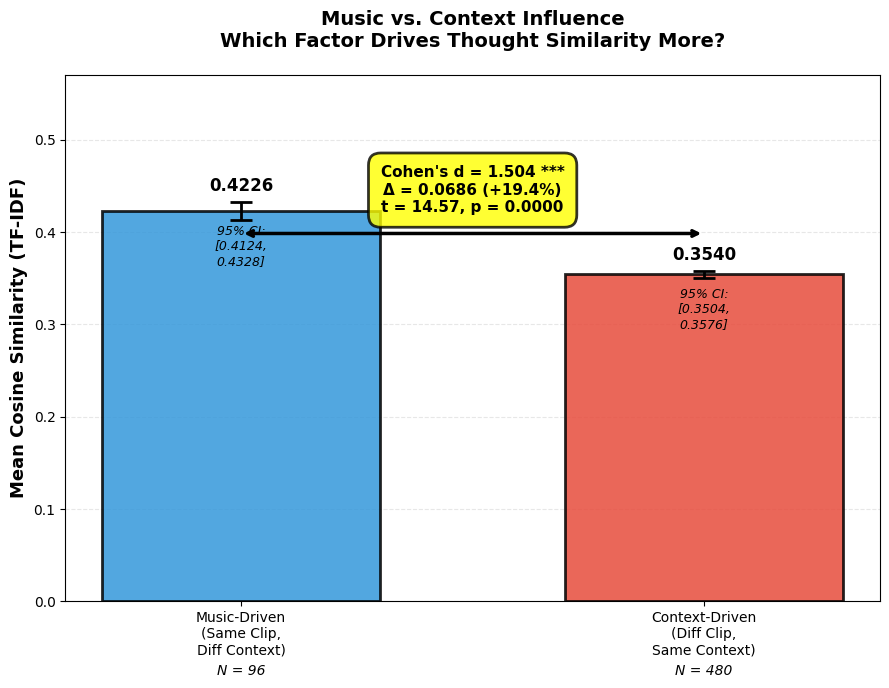

✓ Saved: TFIDF_COMP_music_vs_context.png


/tmp/ipython-input-4090303368.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_c.set_xticklabels(labels_all, rotation=0, ha='center', fontsize=10)


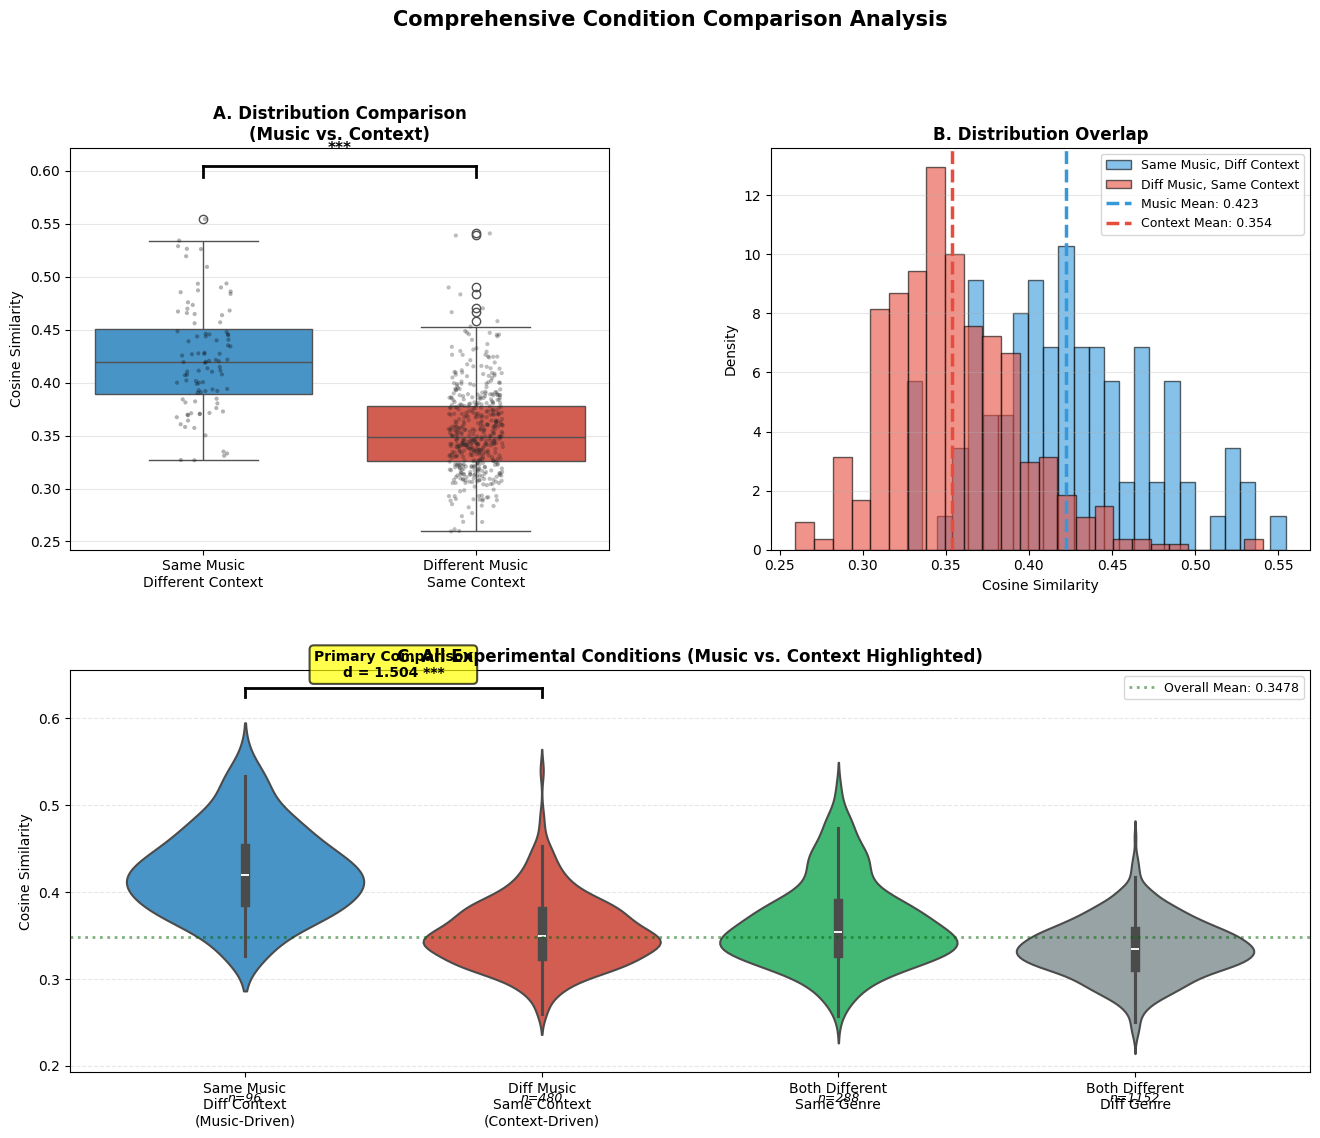

✓ Saved: TFIDF_comprehensive_conditions.png

COMBINED COMPARISONS SUMMARY

                 Comparison             Condition 1 Mean 1             Condition 2 Mean 2 Difference Cohen's d p-value Sig.
Music vs. Context (Primary) Same Clip, Diff Context 0.4226 Diff Clip, Same Context 0.3540     0.0686     1.504  0.0000  ***
 Genre Effect (Both Differ) Same Genre, Both Differ 0.3632 Diff Genre, Both Differ 0.3352     0.0280     0.671  0.0000  ***


In [14]:
# ----------------------------------------------------------------------------
# Figure 1: BAR CHART (Music vs Context with CI and Effect Size)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 7))

categories = ['Music-Driven\n(Same Clip,\nDiff Context)',
              'Context-Driven\n(Diff Clip,\nSame Context)']
means = [music_mean, context_mean]
colors_primary = ['#3498db', '#e74c3c']

# Bar chart
bars = ax.bar(categories, means, color=colors_primary, edgecolor='black',
              linewidth=2, alpha=0.85, width=0.6)

# Error bars (95% CI)
ci_ranges = [
    (music_ci[1] - music_ci[0]) / 2,
    (context_ci[1] - context_ci[0]) / 2
]
ax.errorbar(range(len(means)), means, yerr=ci_ranges, fmt='none',
            ecolor='black', capsize=8, capthick=2, linewidth=2)

# Value labels
for i, (bar, mean, ci, ci_range) in enumerate(zip(bars, means, [music_ci, context_ci], ci_ranges)):
    height = bar.get_height()
    # Mean value
    ax.text(bar.get_x() + bar.get_width()/2., height + ci_range + 0.008,
            f'{mean:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    # 95% CI
    ax.text(bar.get_x() + bar.get_width()/2., height - 0.015,
            f'95% CI:\n[{ci[0]:.4f},\n{ci[1]:.4f}]',
            ha='center', va='top', fontsize=9, style='italic')

# Effect size annotation with arrow
mid_point = (means[0] + means[1]) / 2
y_arrow = mid_point + 0.01
ax.annotate('', xy=(0, y_arrow), xytext=(1, y_arrow),
            arrowprops=dict(arrowstyle='<->', lw=2.5, color='black'))

effect_text = f"Cohen's d = {primary_effect['d']:.3f} {primary_effect['sig']}\n"
effect_text += f"Δ = {primary_effect['diff']:.4f} ({(primary_effect['diff']/context_mean)*100:+.1f}%)\n"
effect_text += f"t = {primary_effect['t']:.2f}, p = {primary_effect['p']:.4f}"
ax.text(0.5, y_arrow + 0.02, effect_text,
        ha='center', va='bottom', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow',
                 edgecolor='black', alpha=0.8, linewidth=2))

# Labels and formatting
ax.set_ylabel('Mean Cosine Similarity (TF-IDF)', fontsize=13, fontweight='bold')
ax.set_title('Music vs. Context Influence\n' +
             'Which Factor Drives Thought Similarity More?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, max(means) * 1.35])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Sample sizes
ax.text(0, -0.08, f'N = {len(music_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')
ax.text(1, -0.08, f'N = {len(context_driven_docs)}',
        transform=ax.transData, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_COMP_music_vs_context.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: TFIDF_COMP_music_vs_context.png")


# ----------------------------------------------------------------------------
# Figure 2: COMPREHENSIVE 4-PANEL COMPARISON
# ----------------------------------------------------------------------------

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)


# PANEL A: Boxplot comparison
# ------------------------------------------------------------------------
ax_a = fig.add_subplot(gs[0, 0])

comparison_data = sim_df_docs[sim_df_docs['condition'].isin([
    'same_clip_diff_context',
    'diff_clip_same_context'
])].copy()

comparison_data['condition_label'] = comparison_data['condition'].map({
    'same_clip_diff_context': 'Same Music\nDifferent Context',
    'diff_clip_same_context': 'Different Music\nSame Context'
})

order = ['Same Music\nDifferent Context', 'Different Music\nSame Context']
palette = ['#e74c3c', '#3498db']

sns.boxplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
            hue='condition_label', palette=palette, legend=False, order=order)
sns.stripplot(data=comparison_data, x='condition_label', y='similarity', ax=ax_a,
              hue='condition_label', palette='dark:black', alpha=0.3, size=3,
              legend=False, order=order)

ax_a.set_title('A. Distribution Comparison\n(Music vs. Context)',
               fontsize=12, fontweight='bold')
ax_a.set_xlabel('')
ax_a.set_ylabel('Cosine Similarity', fontsize=10)
ax_a.grid(axis='y', alpha=0.3)

# Add significance bracket
y_max_a = comparison_data['similarity'].max()
bracket_y_a = y_max_a + 0.05
ax_a.plot([0, 1], [bracket_y_a, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([0, 0], [bracket_y_a - 0.01, bracket_y_a], 'k-', linewidth=2)
ax_a.plot([1, 1], [bracket_y_a - 0.01, bracket_y_a], 'k-', linewidth=2)
ax_a.text(0.5, bracket_y_a + 0.01, primary_effect['sig'],
         ha='center', va='bottom', fontsize=11, fontweight='bold')


# PANEL B: Distribution histogram
# ------------------------------------------------------------------------
ax_b = fig.add_subplot(gs[0, 1])

ax_b.hist(music_driven_docs, bins=25, alpha=0.6, label='Same Music, Diff Context',
          color='#3498db', density=True, edgecolor='black')
ax_b.hist(context_driven_docs, bins=25, alpha=0.6, label='Diff Music, Same Context',
          color='#e74c3c', density=True, edgecolor='black')
ax_b.axvline(music_mean, color='#3498db', linestyle='--', linewidth=2.5,
             label=f'Music Mean: {music_mean:.3f}')
ax_b.axvline(context_mean, color='#e74c3c', linestyle='--', linewidth=2.5,
             label=f'Context Mean: {context_mean:.3f}')

ax_b.set_xlabel('Cosine Similarity', fontsize=10)
ax_b.set_ylabel('Density', fontsize=10)
ax_b.set_title('B. Distribution Overlap',
               fontsize=12, fontweight='bold')
ax_b.legend(fontsize=9, loc='upper right')
ax_b.grid(axis='y', alpha=0.3)


# PANEL C: All conditions violin plot
# ------------------------------------------------------------------------
ax_c = fig.add_subplot(gs[1, :])

order_all = ['same_clip_diff_context', 'diff_clip_same_context',
             'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels_all = ['Same Music\nDiff Context\n(Music-Driven)',
              'Diff Music\nSame Context\n(Context-Driven)',
              'Both Different\nSame Genre',
              'Both Different\nDiff Genre']
palette_all = {
    'same_clip_diff_context': '#3498db',
    'diff_clip_same_context': '#e74c3c',
    'diff_clip_diff_context_same_genre': '#2ecc71',
    'diff_clip_diff_context_diff_genre': '#95a5a6'
}

sns.violinplot(data=sim_df_docs, x='condition', y='similarity', ax=ax_c,
               order=order_all, hue='condition', palette=palette_all,
               legend=False, inner='box', linewidth=1.5)

ax_c.set_xticklabels(labels_all, rotation=0, ha='center', fontsize=10)
ax_c.set_title('C. All Experimental Conditions (Music vs. Context Highlighted)',
               fontsize=12, fontweight='bold')
ax_c.set_xlabel('')
ax_c.set_ylabel('Cosine Similarity', fontsize=10)
ax_c.grid(axis='y', alpha=0.3, linestyle='--')
ax_c.set_axisbelow(True)

# Primary comparison bracket
y_max_c = sim_df_docs['similarity'].max()
bracket_y_c = y_max_c + 0.08
ax_c.plot([0, 1], [bracket_y_c, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([0, 0], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.plot([1, 1], [bracket_y_c - 0.01, bracket_y_c], 'k-', linewidth=2)
ax_c.text(0.5, bracket_y_c + 0.01,
          f"Primary Comparison\nd = {primary_effect['d']:.3f} {primary_effect['sig']}",
          ha='center', va='bottom', fontsize=10, fontweight='bold',
          bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7,
                   edgecolor='black', linewidth=1.5))

# Sample sizes
for i, cond in enumerate(order_all):
    n = len(sim_df_docs[sim_df_docs['condition'] == cond])
    ax_c.text(i, -0.05, f'n={n}', ha='center', va='top',
              transform=ax_c.get_xaxis_transform(), fontsize=9, style='italic')

# Overall mean line
overall_mean = sim_df_docs['similarity'].mean()
ax_c.axhline(y=overall_mean, color='darkgreen', linestyle=':',
             linewidth=2, alpha=0.5, label=f'Overall Mean: {overall_mean:.4f}')
ax_c.legend(loc='upper right', fontsize=9)

plt.suptitle('Comprehensive Condition Comparison Analysis',
            fontsize=15, fontweight='bold', y=0.995)

plt.savefig('/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_comprehensive_conditions.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: TFIDF_comprehensive_conditions.png")


# ----------------------------------------------------------------------------
# SUMMARY TABLE
# ----------------------------------------------------------------------------

print("\n" + "="*70)
print("COMBINED COMPARISONS SUMMARY")
print("="*70)

summary_data = {
    'Comparison': [
        'Music vs. Context (Primary)',
        'Genre Effect (Both Differ)'
    ],
    'Condition 1': [
        'Same Clip, Diff Context',
        'Same Genre, Both Differ'
    ],
    'Mean 1': [
        f"{primary_effect['mean1']:.4f}",
        f"{genre_effect['mean1']:.4f}"
    ],
    'Condition 2': [
        'Diff Clip, Same Context',
        'Diff Genre, Both Differ'
    ],
    'Mean 2': [
        f"{primary_effect['mean2']:.4f}",
        f"{genre_effect['mean2']:.4f}"
    ],
    'Difference': [
        f"{primary_effect['diff']:.4f}",
        f"{genre_effect['diff']:.4f}"
    ],
    "Cohen's d": [
        f"{primary_effect['d']:.3f}",
        f"{genre_effect['d']:.3f}"
    ],
    'p-value': [
        f"{primary_effect['p']:.4f}",
        f"{genre_effect['p']:.4f}"
    ],
    'Sig.': [
        primary_effect['sig'],
        genre_effect['sig']
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(
    '/content/context-framed-listening/NLP_outputs/TFIDF/TFIDF_combined_comparisons_summary.csv',
    index=False
)


#### Omnibus Test

In [15]:
print("\n\n" + "-"*70)
print("OMNIBUS TEST: Overall Condition Differences")
print("-"*70)

conditions_list = sim_df_docs['condition'].unique()
groups = [sim_df_docs[sim_df_docs['condition'] == cond]['similarity'] for cond in conditions_list]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions_list)} conditions:")
print(f"F({len(conditions_list)-1}, {len(sim_df_docs)-len(conditions_list)}) = {f_stat:.3f}, p = {p_anova:.4e}")

# Calculate eta-squared (effect size for ANOVA)
ss_between = sum(len(g) * (g.mean() - sim_df_docs['similarity'].mean())**2 for g in groups)
ss_total = sum((sim_df_docs['similarity'] - sim_df_docs['similarity'].mean())**2)
eta_squared = ss_between / ss_total

print(f"η² = {eta_squared:.4f}")

if p_anova < 0.001:
    print("→ Conditions are HIGHLY significantly different overall (p < .001)")
elif p_anova < 0.01:
    print("→ Conditions are significantly different overall (p < .01)")
elif p_anova < 0.05:
    print("→ Conditions show significant differences (p < .05)")
else:
    print("→ No significant differences between conditions")



----------------------------------------------------------------------
OMNIBUS TEST: Overall Condition Differences
----------------------------------------------------------------------

One-way ANOVA across all 4 conditions:
F(3, 2012) = 180.804, p = 8.5808e-104
η² = 0.2123
→ Conditions are HIGHLY significantly different overall (p < .001)


### SUMMARY

In [16]:
# ============================================================================
# FINAL COMPREHENSIVE SUMMARY
# ============================================================================

print("\n\n" + "="*70)
print("=" * 70)
print("FINAL COMPREHENSIVE SUMMARY: TF-IDF DOCUMENT-LEVEL ANALYSIS")
print("=" * 70)
print("="*70)
print(f"\nAnalysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Total METdocs Analyzed: {len(METdocs)}")
print(f"Total Pairwise Comparisons: {len(sim_df_docs)}")
print(f"Unique Clips: {METdocs['clip_name'].nunique()}")
print(f"Unique Contexts: {METdocs['context_word'].nunique()}")
print(f"Unique Genres: {METdocs['genre_code'].nunique()}")

# ============================================================================
# SECTION 1: PRIMARY RESEARCH QUESTION
# ============================================================================

print("\n" + "="*70)
print("1. PRIMARY RESEARCH QUESTION")
print("="*70)
print("Does CONTEXT or MUSIC drive thought similarity more?")
print("-"*70)

music_driven = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']

music_mean = music_driven.mean()
context_mean = context_driven.mean()
music_std = music_driven.std()
context_std = context_driven.std()
diff = music_mean - context_mean
percent_diff = (diff / context_mean) * 100

# Calculate confidence intervals
from scipy import stats as sp_stats
music_ci = sp_stats.t.interval(0.95, len(music_driven)-1,
                                loc=music_mean,
                                scale=music_std/np.sqrt(len(music_driven)))
context_ci = sp_stats.t.interval(0.95, len(context_driven)-1,
                                  loc=context_mean,
                                  scale=context_std/np.sqrt(len(context_driven)))

print("\nMUSIC-DRIVEN (Same Clip, Different Context):")
print(f"  Mean:  {music_mean:.4f}")
print(f"  SD:    {music_std:.4f}")
print(f"  95% CI: [{music_ci[0]:.4f}, {music_ci[1]:.4f}]")
print(f"  N:     {len(music_driven)} document pairs")

print("\nCONTEXT-DRIVEN (Different Clip, Same Context):")
print(f"  Mean:  {context_mean:.4f}")
print(f"  SD:    {context_std:.4f}")
print(f"  95% CI: [{context_ci[0]:.4f}, {context_ci[1]:.4f}]")
print(f"  N:     {len(context_driven)} document pairs")

print(f"\nSTATISTICAL COMPARISON:")
print(f"  Difference (Music - Context): {diff:.4f} ({percent_diff:+.1f}%)")
print(f"  t-statistic: {primary_effect['t']:.3f}")
print(f"  p-value: {primary_effect['p']:.4f} {primary_effect['sig']}")
print(f"  Cohen's d: {primary_effect['d']:.3f}")

# Interpret effect size
if abs(primary_effect['d']) < 0.2:
    effect_interp = "negligible"
elif abs(primary_effect['d']) < 0.5:
    effect_interp = "small"
elif abs(primary_effect['d']) < 0.8:
    effect_interp = "medium"
else:
    effect_interp = "large"
print(f"  Effect size interpretation: {effect_interp}")

print("\n" + "-"*70)
print("KEY FINDING:")
print("-"*70)
if primary_effect['p'] < 0.05:
    if music_mean > context_mean:
        print(f"✓ MUSIC drives thought similarity MORE than context")
        print(f"  • Aggregated thoughts are {percent_diff:.1f}% more similar when")
        print(f"    listeners hear the same music in different contexts")
        print(f"  • This suggests music has stronger lexical influence on METs")
    else:
        print(f"✓ CONTEXT drives thought similarity MORE than music")
        print(f"  • Aggregated thoughts are {abs(percent_diff):.1f}% more similar when")
        print(f"    listeners experience the same context with different music")
        print(f"  • This suggests context has stronger lexical influence on METs")
else:
    print(f"✗ Music and context have COMPARABLE influence on thought similarity")
    print(f"  • No significant difference detected (p = {primary_effect['p']:.4f})")
    print(f"  • Both factors may contribute equally to lexical patterns")

# ============================================================================
# SECTION 2: BINARY FACTOR EFFECTS
# ============================================================================

print("\n\n" + "="*70)
print("2. BINARY FACTOR EFFECTS")
print("="*70)
print("How does sharing each factor (clip/context/genre) affect similarity?")
print("-"*70)

# Create comprehensive binary comparison table
binary_comparisons_table = []

print("\nCLIP EFFECT (Same Clip vs. Different Clip):")
print(f"  Same Clip:      M = {clip_comp['mean_same']:.4f}, SD = {sim_df_docs[sim_df_docs['same_clip']]['similarity'].std():.4f} (N = {clip_comp['n_same']})")
print(f"  Different Clip: M = {clip_comp['mean_diff']:.4f}, SD = {sim_df_docs[~sim_df_docs['same_clip']]['similarity'].std():.4f} (N = {clip_comp['n_diff']})")
print(f"  Difference:     {clip_comp['diff']:.4f}")
print(f"  Cohen's d:      {clip_comp['d']:.3f} {clip_comp['sig']}")
binary_comparisons_table.append(('Clip', clip_comp['d'], clip_comp['sig'], clip_comp['diff']))

print("\nCONTEXT EFFECT (Same Context vs. Different Context):")
print(f"  Same Context:      M = {context_comp['mean_same']:.4f}, SD = {sim_df_docs[sim_df_docs['same_context']]['similarity'].std():.4f} (N = {context_comp['n_same']})")
print(f"  Different Context: M = {context_comp['mean_diff']:.4f}, SD = {sim_df_docs[~sim_df_docs['same_context']]['similarity'].std():.4f} (N = {context_comp['n_diff']})")
print(f"  Difference:        {context_comp['diff']:.4f}")
print(f"  Cohen's d:         {context_comp['d']:.3f} {context_comp['sig']}")
binary_comparisons_table.append(('Context', context_comp['d'], context_comp['sig'], context_comp['diff']))

print("\nGENRE EFFECT (Same Genre vs. Different Genre):")
print(f"  Same Genre:      M = {genre_comp['mean_same']:.4f}, SD = {sim_df_docs[sim_df_docs['same_genre']]['similarity'].std():.4f} (N = {genre_comp['n_same']})")
print(f"  Different Genre: M = {genre_comp['mean_diff']:.4f}, SD = {sim_df_docs[~sim_df_docs['same_genre']]['similarity'].std():.4f} (N = {genre_comp['n_diff']})")
print(f"  Difference:      {genre_comp['diff']:.4f}")
print(f"  Cohen's d:       {genre_comp['d']:.3f} {genre_comp['sig']}")
binary_comparisons_table.append(('Genre', genre_comp['d'], genre_comp['sig'], genre_comp['diff']))

# Rank by effect size
binary_comparisons_table.sort(key=lambda x: abs(x[1]), reverse=True)

print("\n" + "-"*70)
print("RANKING BY EFFECT SIZE (|Cohen's d|):")
print("-"*70)
for i, (factor, d, sig, diff) in enumerate(binary_comparisons_table, 1):
    print(f"  {i}. {factor:8s}: d = {d:+.3f} {sig:3s}  (Δ = {diff:+.4f})")

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
winner = binary_comparisons_table[0]
print(f"• {winner[0].upper()} shows the STRONGEST effect on thought similarity")
print(f"  (d = {winner[1]:.3f}, clearly {'significant' if winner[2] != 'n.s.' else 'non-significant'})")
for factor, d, sig, diff in binary_comparisons_table[1:]:
    if sig != 'n.s.':
        print(f"• {factor.capitalize()} also has a {'significant' if abs(d) > 0.3 else 'modest'} effect (d = {d:.3f})")
    else:
        print(f"• {factor.capitalize()} shows minimal/no significant effect (d = {d:.3f}, {sig})")

# ============================================================================
# SECTION 3: CONTEXT-SPECIFIC ANALYSIS
# ============================================================================

print("\n\n" + "="*70)
print("3. CONTEXT-SPECIFIC ANALYSIS")
print("="*70)
print("Do specific contexts produce distinctive thought patterns?")
print("-"*70)

print("\n3.1 WITHIN-CONTEXT SIMILARITY (Same Context, Different Music)")
print("-"*70)
print("Ranking contexts by thought convergence:\n")
for i, row in within_context_df.iterrows():
    print(f"  {i+1}. {row['context'].upper():12s}: M = {row['mean']:.4f}, CV = {row['cv']:.4f} (N = {row['n']})")

most_convergent_ctx = within_context_df.iloc[0]
most_divergent_ctx = within_context_df.iloc[-1]
print(f"\n→ {most_convergent_ctx['context'].upper()} produces MOST CONVERGENT thoughts")
print(f"  (Highest mean similarity, lowest variability)")
print(f"→ {most_divergent_ctx['context'].upper()} produces MOST DIVERSE thoughts")
print(f"  (Lower similarity, higher variability)")

# Significant pairwise differences
print("\n3.2 PAIRWISE CONTEXT COMPARISONS")
print("-"*70)
sig_context_pairs = context_pairs_df[context_pairs_df['sig'] != 'n.s.']
if len(sig_context_pairs) > 0:
    print(f"Found {len(sig_context_pairs)} significant pairwise differences:\n")
    for _, row in sig_context_pairs.iterrows():
        print(f"  {row['context1'].upper()} vs {row['context2'].upper()}:")
        print(f"    Difference: {row['difference']:.4f}, d = {row['d']:.3f} {row['sig']}")
else:
    print("No significant pairwise differences between contexts")

# Music vs Context by context
print("\n3.3 MUSIC VS. CONTEXT EFFECTS BY CONTEXT")
print("-"*70)
if len(context_moderator_df) > 0:
    music_dominant_ctx = context_moderator_df[
        (context_moderator_df['difference'] > 0) &
        (context_moderator_df['sig'] != 'n.s.')
    ]
    context_dominant_ctx = context_moderator_df[
        (context_moderator_df['difference'] < 0) &
        (context_moderator_df['sig'] != 'n.s.')
    ]

    if len(music_dominant_ctx) > 0:
        print(f"\nContexts where MUSIC dominates ({len(music_dominant_ctx)}):")
        for _, row in music_dominant_ctx.iterrows():
            print(f"  • {row['context'].upper()}: d = {row['effect_size']:.3f} {row['sig']}")

    if len(context_dominant_ctx) > 0:
        print(f"\nContexts where CONTEXT dominates ({len(context_dominant_ctx)}):")
        for _, row in context_dominant_ctx.iterrows():
            print(f"  • {row['context'].upper()}: d = {row['effect_size']:.3f} {row['sig']}")

    no_diff_ctx = context_moderator_df[context_moderator_df['sig'] == 'n.s.']
    if len(no_diff_ctx) > 0:
        print(f"\nContexts with NO significant difference ({len(no_diff_ctx)}):")
        for _, row in no_diff_ctx.iterrows():
            print(f"  • {row['context'].upper()}")

# ============================================================================
# SECTION 4: GENRE-SPECIFIC ANALYSIS
# ============================================================================

print("\n\n" + "="*70)
print("4. GENRE-SPECIFIC ANALYSIS")
print("="*70)
print("Do specific genres produce distinctive thought patterns?")
print("-"*70)

print("\n4.1 WITHIN-GENRE SIMILARITY (Same Genre, Different Clips)")
print("-"*70)
print("Ranking genres by thought convergence:\n")
for i, row in within_genre_df.iterrows():
    print(f"  {i+1}. {row['genre'].upper():12s}: M = {row['mean']:.4f}, CV = {row['cv']:.4f} (N = {row['n']})")

most_convergent_genre = within_genre_df.iloc[0]
most_divergent_genre = within_genre_df.iloc[-1]
print(f"\n→ {most_convergent_genre['genre'].upper()} produces MOST CONVERGENT thoughts")
print(f"  (Highest mean similarity, lowest variability)")
print(f"→ {most_divergent_genre['genre'].upper()} produces MOST DIVERSE thoughts")
print(f"  (Lower similarity, higher variability)")

# Significant pairwise differences
print("\n4.2 PAIRWISE GENRE COMPARISONS")
print("-"*70)
sig_genre_pairs = genre_pairs_df[genre_pairs_df['sig'] != 'n.s.']
if len(sig_genre_pairs) > 0:
    print(f"Found {len(sig_genre_pairs)} significant pairwise differences:\n")
    for _, row in sig_genre_pairs.iterrows():
        print(f"  {row['genre1'].upper()} vs {row['genre2'].upper()}:")
        print(f"    Difference: {row['difference']:.4f}, d = {row['d']:.3f} {row['sig']}")
else:
    print("No significant pairwise differences between genres")

# Music vs Context by genre
print("\n4.3 MUSIC VS. CONTEXT EFFECTS BY GENRE")
print("-"*70)
if len(genre_moderator_df) > 0:
    music_dominant_genre = genre_moderator_df[
        (genre_moderator_df['difference'] > 0) &
        (genre_moderator_df['sig'] != 'n.s.')
    ]
    context_dominant_genre = genre_moderator_df[
        (genre_moderator_df['difference'] < 0) &
        (genre_moderator_df['sig'] != 'n.s.')
    ]

    if len(music_dominant_genre) > 0:
        print(f"\nGenres where MUSIC dominates ({len(music_dominant_genre)}):")
        for _, row in music_dominant_genre.iterrows():
            print(f"  • {row['genre'].upper()}: d = {row['effect_size']:.3f} {row['sig']}")

    if len(context_dominant_genre) > 0:
        print(f"\nGenres where CONTEXT dominates ({len(context_dominant_genre)}):")
        for _, row in context_dominant_genre.iterrows():
            print(f"  • {row['genre'].upper()}: d = {row['effect_size']:.3f} {row['sig']}")

    no_diff_genre = genre_moderator_df[genre_moderator_df['sig'] == 'n.s.']
    if len(no_diff_genre) > 0:
        print(f"\nGenres with NO significant difference ({len(no_diff_genre)}):")
        for _, row in no_diff_genre.iterrows():
            print(f"  • {row['genre'].upper()}")

# Genre effect when both differ
print("\n4.4 GENRE EFFECT (When Both Clip & Context Differ)")
print("-"*70)
print(f"Same Genre (both differ):     M = {genre_effect['mean1']:.4f} (N = {genre_effect['n1']})")
print(f"Different Genre (both differ): M = {genre_effect['mean2']:.4f} (N = {genre_effect['n2']})")
print(f"Difference:                    {genre_effect['diff']:.4f}")
print(f"Cohen's d:                     {genre_effect['d']:.3f} {genre_effect['sig']}")
if genre_effect['sig'] != 'n.s.':
    print("\n→ Genre creates significant lexical coherence even when")
    print("  both clip and context differ")
else:
    print("\n→ Genre does NOT create significant coherence when")
    print("  both clip and context differ")

# ============================================================================
# SECTION 5: GENRE × CONTEXT INTERACTION
# ============================================================================

print("\n\n" + "="*70)
print("5. GENRE × CONTEXT INTERACTION")
print("="*70)
print("Do certain genres work better with certain contexts?")
print("-"*70)

if len(genre_context_df) > 0:
    print("\nTop 3 Genre-Context combinations (highest similarity):")
    top_combos = genre_context_df.nlargest(3, 'mean')
    for i, (_, row) in enumerate(top_combos.iterrows(), 1):
        print(f"  {i}. {row['genre'].upper()} + {row['context'].upper()}: M = {row['mean']:.4f}")

    print("\nBottom 3 Genre-Context combinations (lowest similarity):")
    bottom_combos = genre_context_df.nsmallest(3, 'mean')
    for i, (_, row) in enumerate(bottom_combos.iterrows(), 1):
        print(f"  {i}. {row['genre'].upper()} + {row['context'].upper()}: M = {row['mean']:.4f}")

    print("\n→ Certain genre-context pairings produce more lexically similar thoughts")
    print("  (See Fig6_genre_context_interaction.png for full heatmap)")

# ============================================================================
# SECTION 6: CONSISTENCY ANALYSIS
# ============================================================================

print("\n\n" + "="*70)
print("6. CONSISTENCY ANALYSIS")
print("="*70)
print("Which factors produce more consistent vs. variable thought patterns?")
print("-"*70)

# Overall comparison
genre_mean_cv = genre_consistency_df['cv'].mean()
context_mean_cv = context_consistency_df['cv'].mean()

print("\nOVERALL CONSISTENCY (Lower CV = More Consistent):")
print(f"  Genre:   Mean CV = {genre_mean_cv:.4f}")
print(f"  Context: Mean CV = {context_mean_cv:.4f}")

# Test if difference is significant
if len(genre_consistency_df) >= 2 and len(context_consistency_df) >= 2:
    t_stat, p_val = stats.ttest_ind(
        genre_consistency_df['cv'],
        context_consistency_df['cv']
    )
    print(f"  t-test: t = {t_stat:.3f}, p = {p_val:.4f}")

    if p_val < 0.05:
        if genre_mean_cv < context_mean_cv:
            print("\n→ GENRES produce SIGNIFICANTLY more consistent thought patterns")
        else:
            print("\n→ CONTEXTS produce SIGNIFICANTLY more consistent thought patterns")
    else:
        print("\n→ No significant difference in consistency between genres and contexts")
        print("  (Both factors show similar variability)")

# Music vs Context consistency
print("\n\nMUSIC VS. CONTEXT CONSISTENCY:")
print("-"*70)

# Context analysis
if len(context_consistency_comparison_df) > 0:
    sig_ctx_consistency = context_consistency_comparison_df[
        context_consistency_comparison_df['levene_p'] < 0.05
    ]
    print(f"\nContexts with significant consistency differences: {len(sig_ctx_consistency)}/{len(context_consistency_comparison_df)}")

    if len(sig_ctx_consistency) > 0:
        music_consistent_ctx = sig_ctx_consistency[sig_ctx_consistency['cv_difference'] < 0]
        context_consistent_ctx = sig_ctx_consistency[sig_ctx_consistency['cv_difference'] > 0]

        if len(music_consistent_ctx) > 0:
            print(f"  Music more consistent: {', '.join(music_consistent_ctx['context'].str.upper())}")
        if len(context_consistent_ctx) > 0:
            print(f"  Context more consistent: {', '.join(context_consistent_ctx['context'].str.upper())}")

# Genre analysis
if len(genre_consistency_comparison_df) > 0:
    sig_genre_consistency = genre_consistency_comparison_df[
        genre_consistency_comparison_df['levene_p'] < 0.05
    ]
    print(f"\nGenres with significant consistency differences: {len(sig_genre_consistency)}/{len(genre_consistency_comparison_df)}")

    if len(sig_genre_consistency) > 0:
        music_consistent_genre = sig_genre_consistency[sig_genre_consistency['cv_difference'] < 0]
        context_consistent_genre = sig_genre_consistency[sig_genre_consistency['cv_difference'] > 0]

        if len(music_consistent_genre) > 0:
            print(f"  Music more consistent: {', '.join(music_consistent_genre['genre'].str.upper())}")
        if len(context_consistent_genre) > 0:
            print(f"  Context more consistent: {', '.join(context_consistent_genre['genre'].str.upper())}")

# ============================================================================
# SECTION 7: METHODOLOGICAL NOTES
# ============================================================================

print("\n\n" + "="*70)
print("7. METHODOLOGICAL NOTES & LIMITATIONS")
print("="*70)

print("\nSTRENGTHS OF DOCUMENT-LEVEL TF-IDF ANALYSIS:")
print("-"*70)
print("✓ Captures lexical patterns at aggregated level")
print("✓ Identifies which conditions produce similar vocabulary/word usage")
print("✓ TF-IDF weights terms by importance within documents")
print("✓ Sufficient text length (aggregated METdocs) for reliable TF-IDF vectors")
print("✓ Complements semantic analyses (BERT, Word2Vec)")

print("\nLIMITATIONS:")
print("-"*70)
print("✗ Document-level aggregation prevents testing same_clip_same_context")
print("  (same clip + same context = same document, similarity = 1.0)")
print("✗ Cannot directly test individual-level variation")
print("✗ Bag-of-words approach: ignores word order and context")
print("✗ Sensitive to exact word matches (unlike semantic embeddings)")
print("✗ May miss semantic similarity when different words convey same meaning")

print("\nCOMPLEMENTARY ANALYSES RECOMMENDED:")
print("-"*70)
print("• Individual-level analysis (BERT/Word2Vec) for:")
print("  - Testing same_clip_same_context condition")
print("  - Examining individual variation")
print("  - Capturing semantic similarity beyond exact lexical matches")
print("• Mixed-effects modeling for:")
print("  - Testing interaction effects (Genre × Context)")
print("  - Accounting for nested data structure")
print("  - Modeling individual and clip-level variation")

# ============================================================================
# SECTION 8: OUTPUT FILES
# ============================================================================

print("\n\n" + "="*70)
print("8. OUTPUT FILES GENERATED")
print("="*70)

output_summary = {
    'Core Analysis Files': [
        'TFIDF_scores.csv',
        'TFIDF_cosineMatrix.csv',
        'TFIDF_similarity_by_condition.csv',
        'TFIDF_combined_comparisons_summary.csv'
    ],
    'Context-Specific Files': [
        'TFIDF_within_context_analysis.csv',
        'TFIDF_context_pairwise_comparisons.csv',
        'TFIDF_context_moderator_music_vs_context.csv',
        'TFIDF_context_consistency.csv',
        'TFIDF_context_music_vs_context_consistency.csv'
    ],
    'Genre-Specific Files': [
        'TFIDF_within_genre_analysis.csv',
        'TFIDF_genre_pairwise_comparisons.csv',
        'TFIDF_genre_moderator_music_vs_context.csv',
        'TFIDF_genre_consistency.csv',
        'TFIDF_genre_music_vs_context_consistency.csv'
    ],
    'Interaction Files': [
        'TFIDF_genre_context_interaction.csv'
    ],
    'Visualization Files': [
        'TFIDF_heatmap.png',
        'TFIDF_binary_comparisons.png',
        'TFIDF_within_factor_comparison.png',
        'TFIDF_pairwise_comparison.png',
        'TFIDF_music_vs_context_comparison.png',
        'TFIDF_consistency_comparison.png',
        'TFIDF_similarity_matrices.png',
        'TFIDF_genre_context_interaction2.png',
        'TFIDF_COMP_music_vs_context.png',
        'TFIDF_comprehensive_conditions.png'
    ]
}

for category, files in output_summary.items():
    print(f"\n{category}:")
    print("-" * 70)
    for file in files:
        print(f"  • {file}")

print("\n" + "-"*70)
print(f"All files saved to: /content/context-framed-listening/NLP_outputs/TFIDF/")
print("-"*70)

# ============================================================================
# SECTION 9: KEY TAKEAWAYS
# ============================================================================

print("\n\n" + "="*70)
print("9. KEY TAKEAWAYS")
print("="*70)

key_takeaways = []

# Takeaway 1: Primary comparison
if primary_effect['p'] < 0.05:
    if music_mean > context_mean:
        key_takeaways.append(
            f"1. MUSIC drives lexical similarity MORE than context\n"
            f"   • Effect size: d = {primary_effect['d']:.3f} {primary_effect['sig']}\n"
            f"   • Thoughts {percent_diff:.1f}% more similar when hearing same music"
        )
    else:
        key_takeaways.append(
            f"1. CONTEXT drives lexical similarity MORE than music\n"
            f"   • Effect size: d = {primary_effect['d']:.3f} {primary_effect['sig']}\n"
            f"   • Thoughts {abs(percent_diff):.1f}% more similar with same context"
        )
else:
    key_takeaways.append(
        f"1. Music and context have COMPARABLE influence\n"
        f"   • No significant difference (p = {primary_effect['p']:.4f})\n"
        f"   • Both factors contribute to lexical patterns"
    )

# Takeaway 2: Binary effects
strongest = binary_comparisons_table[0]
key_takeaways.append(
    f"2. {strongest[0].upper()} shows the strongest binary effect\n"
    f"   • Cohen's d = {strongest[1]:.3f} {strongest[2]}\n"
    f"   • Sharing {strongest[0].lower()} increases similarity by {strongest[3]:.4f}"
)

# Takeaway 3: Context-specific
if len(context_moderator_df) > 0:
    music_dom_count = len(context_moderator_df[
        (context_moderator_df['difference'] > 0) &
        (context_moderator_df['sig'] != 'n.s.')
    ])
    context_dom_count = len(context_moderator_df[
        (context_moderator_df['difference'] < 0) &
        (context_moderator_df['sig'] != 'n.s.')
    ])

    if music_dom_count > context_dom_count:
        key_takeaways.append(
            f"3. Music effects dominate in most contexts\n"
            f"   • {music_dom_count}/{len(context_moderator_df)} contexts show music > context\n"
            f"   • Context-specific patterns exist but music prevails"
        )
    elif context_dom_count > music_dom_count:
        key_takeaways.append(
            f"3. Context effects dominate in most contexts\n"
            f"   • {context_dom_count}/{len(context_moderator_df)} contexts show context > music\n"
            f"   • Music-specific patterns exist but context prevails"
        )
    else:
        key_takeaways.append(
            f"3. Music vs. context effects vary by specific context\n"
            f"   • No clear winner: effects balanced across contexts\n"
            f"   • Suggests complex interaction patterns"
        )

# Takeaway 4: Genre-specific
if len(genre_moderator_df) > 0:
    if genre_effect['sig'] != 'n.s.':
        key_takeaways.append(
            f"4. Genre creates lexical coherence independently\n"
            f"   • d = {genre_effect['d']:.3f} {genre_effect['sig']}\n"
            f"   • Same genre = similar vocabulary even when clip & context differ"
        )
    else:
        key_takeaways.append(
            f"4. Genre effects are context-dependent\n"
            f"   • No standalone genre effect when both factors differ\n"
            f"   • Genre may interact with other factors"
        )

# Takeaway 5: Consistency
if len(context_consistency_comparison_df) > 0 or len(genre_consistency_comparison_df) > 0:
    sig_consistency_count = 0
    if len(context_consistency_comparison_df) > 0:
        sig_consistency_count += len(context_consistency_comparison_df[
            context_consistency_comparison_df['levene_p'] < 0.05
        ])
    if len(genre_consistency_comparison_df) > 0:
        sig_consistency_count += len(genre_consistency_comparison_df[
            genre_consistency_comparison_df['levene_p'] < 0.05
        ])

    if sig_consistency_count > 0:
        key_takeaways.append(
            f"5. Music vs. context consistency varies by factor level\n"
            f"   • {sig_consistency_count} factor levels show significant consistency differences\n"
            f"   • Some contexts/genres show more variable thought patterns"
        )

# Print all takeaways
for takeaway in key_takeaways:
    print(f"\n{takeaway}")

# ============================================================================
# FINAL STATEMENT
# ============================================================================

print("\n\n" + "="*70)
print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("="*70)
print(f"\nCompleted: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nFor questions or issues, contact: Hazel A. van der Walle")
print("Durham University, Music Department")
print("GitHub: https://github.com/HazelvdW/context-framed-listening")
print("\n" + "="*70)



FINAL COMPREHENSIVE SUMMARY: TF-IDF DOCUMENT-LEVEL ANALYSIS

Analysis Date: 2025-10-29 13:31
Total METdocs Analyzed: 64
Total Pairwise Comparisons: 2016
Unique Clips: 16
Unique Contexts: 4
Unique Genres: 4

1. PRIMARY RESEARCH QUESTION
Does CONTEXT or MUSIC drive thought similarity more?
----------------------------------------------------------------------

MUSIC-DRIVEN (Same Clip, Different Context):
  Mean:  0.4226
  SD:    0.0504
  95% CI: [0.4124, 0.4328]
  N:     96 document pairs

CONTEXT-DRIVEN (Different Clip, Same Context):
  Mean:  0.3540
  SD:    0.0403
  95% CI: [0.3504, 0.3576]
  N:     480 document pairs

STATISTICAL COMPARISON:
  Difference (Music - Context): 0.0686 (+19.4%)
  t-statistic: 14.567
  p-value: 0.0000 ***
  Cohen's d: 1.504
  Effect size interpretation: large

----------------------------------------------------------------------
KEY FINDING:
----------------------------------------------------------------------
✓ MUSIC drives thought similarity MORE than